# Costa Rican Household Poverty Level Prediction
또 다른 Kaggle challenge에 온걸 환영한다. 코스타리카 가구 가난 수준 예측 공모전의 목적은 개인과 가정의 특성 모두를 사용하여 가정의 가난 레벨을 예측하기 위한 머신러닝 모델을 개발하는것이다. 이 "좋은 것을 위한 더이터 과학" 프로젝트는 사람들이 광고를 클릭하는 것보다 사회 적으로 더 유익한 일에 우리의 기술들을 투입할 기회를 제공한다.

이 노트북에서, 우리는 완벽한 머신러닝 솔류션을 천천히 소개할 것이다.  
1. 문제를 소개
2. Dataset에 EDA(Exploratory Data Analysis) 수행
3. Feature engineering
4. 여러 머신러닝 model을 시험
5. model selection
6. model을 최적화하기 위한 작업
7. model의 출력을 inspection & draw

이 노트북은 leaderboard의 상위에 오르지 못할 수도 있지만, 향후 머신 러닝 프로젝트를 위한 탄탄한 기반을 제공하기 위한 교육 도구로 사용된다. Kaggle 프로젝트는 우리에게 기계학습에 대해 많은 것을 알려줄 수 있지만, leaderboard의 상위에 도달하는데 사용되는 몇 가지 전략들은 모범 사례가 아니다. 따라서 여기서 우리는 매우 좋은 (비록 1위는 아니지만) 머신러닝 솔류션을 계속 구축할 것이다. Kaggle 프로젝트는 대회이지만, 대회를 가장한 "머신 러닝 교육"으로 가장 잘 묘사된다고 생각한다.

만약 너가 이 작업에 대한 후속 작업(follow-up) 원한다면, 나는 이 문제를 위한 [Featuretools](https://featuretools.alteryx.com/en/stable/#minute-quick-start)와 함께 [자동화된 특징 엔지니어링(Automated Feature Engineering)](https://www.kaggle.com/code/willkoehrsen/featuretools-for-good/notebook)을 사용한 커널을 포함한 추가 작업이 있다.(leaderboard 점수가 약간 더 높다.)(너가 나의 글쓰기 스타일과 설명이 맘에든다면, 나는 [Toward Data Science](https://williamkoehrsen.medium.com/)에 글을 올린다.)

## Problem and Data Explanation
이 competition의 data는 `train.csv`와 `test.csv`의 두가지 파일이 제공된다. training set은 9557개의 row와 143개의 columns를 가지고 tseting set은 23856개의 row와 142개의 column을 가진다. 각 row는 한 **개인**을 나타내며 각 column은 **개인 또는 개인의 가구를 위한 특성**이다. training set은 1~4 poverty level로 표현된 competition의 label인 Target column을 추가로 가지고 있다. 값 1은 가장 극심한 poverty이다.

이것은 **supervised multi-class classification 머신러닝 문제**이다.

- **Supervised**: training data에 label들이 함께 제공
- **Multi-class classification**: Label들은 4개의 클래스가 있는 이산 값

### objective
목표는 **가구 레벨**에서 빈곤을 예측하는 것이다. 우리는 개인 수준에 대한 데이터를 제공받으며 각 개인은 고유한 특징을 가지고 있지만 그들의 가정에 대한 정보도 가지고 있다. 이 task 위한 dataset을 만들려면, 각 가정에 대한 개별 데이터의 집계를 몇 가지 수행해야 한다. 게다가, 우리는 test set의 모든 개인에 대해 예측을 해야 하지만, "*가장만 채점에 사용된다*"는 것은 우리가 가구 단위로 poverty을 예측하기를 원한다는 것을 의미한다.

**Important note: training data에 한 가구의 모든 구성원이 동일한 label을 가져야 하지만, 동일한 가구의 개인이 서로 다른 label을 갖는 오류가 있다. 이러한 경우 각 가구의 가장에 대한 label을 사용하도록 하며, 이는 parentesco1 == 1.0인 행으로 식별할 수 있다.** 우리는 이 문제를 해결하는 방법에 대해서는 노트북에 설명한다.(더 많은 정보는 [competition main discussion](https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/discussion/61403)을 봐라.)

Target level
```
1 = extreme poverty 
2 = moderate poverty 
3 = vulnerable households 
4 = non vulnerable households
```

모든 143개의 columns에 대한 설명은 [competition documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data) 확인할 수 있지만, 몇 가지 알아야할 사향은 다음과 같다.
- **id**: 각 개인의 고유 식별자, 이것은 우리가 사용하는 기능이 되어서는 안된다.
- **idhogar**: 각 가정의 고유 식별자, 이 variable은 특징이 아니지만, 한 가구의 모든 개인이 동일한 식별자를 가지므로 가구별로 개인을 그룹화하는데 사용된다.
- **parentesco1**: 이 사람이 가장인지 여부를 나타낸다.
- **Target**: label, 한 가구의 모든 구성원에 대해 동일해야 한다.

model을 만들 때, 우리는 *가장의 poverty level에 대한 라벨*을 각 가정에 부착하여 가구 단위로 교육할 것이다. raw data는 가정와 개인의 특징이 모두 혼합되어 있으며 개별데이터의 경우, 우리는 각 가정에 대해 이것을 합치는 방법을 알아야할 것이다. 일부 개인은 *가장이 없는 가정*에 속한다. 이것은 불행하게도 우리가 이 데이터를 훈련에 사용할 수 없다는 것을 의미한다.데이터에 대한 이러한 문제는 완벽히 **real-world** data의 전형적이고 이런 이유로 이 문제는 data science 작업에서 만나게 될 데이터 세트에 대한 훌륭한 준비이다.

### Metric
궁극적으로 우리는 가정의 정수범위 poverty level을 예측할 수 있는 머신러닝 model을 만들기를 원한다. 우리의 예측은 **Macro F1 Score**로 편가될 것이다. 너는 precision과 recall의 조화 평균인 이진 분류 문제에 대한 [standard F1 score](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)를 잘 알고 있을 것입니다.

$$F1=\frac{2}{\frac{1}{recall}+\frac{1}{precision}}=2⋅\frac{precision⋅recall}{precision+recall}$$

multi-class problems의 경우, 우리는 각 클래스의 F1 점수를 평균해야 합니다. macro F1 score는 label 불균형을 고려하지 않고 각 클래스에 대한 F1 score를 평균합니다.

$$Macro F1 = \frac{F1 Class 1 + F1 Class 2 + F1 Class 3 + F1 Class 4}{4}$$

다시 말해, 각 label의 발생 횟수는 macro(매크로)를 사용할 때 계산에 반영되지 않는다("weighted(가중치)" 점수를 사용할 때 반영된다).(차이에 대한 자세한 내용은 [Scikit-Learn Documentation for F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 또는 이 [Stack Exchange 질문과 답변](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)을 참조해라.) 성능을 평가하려면, 다음 코드를 사용할 수 있다.
```python
from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
```

이 문제의 경우, label이 불균형하므로 평가 메트릭에 매크로 평균을 사용하는 것이 조금 이상하지만, 이는 주최자가 내린 결정이지 변경할 수 있는 것은 아닙니다! 자신의 작업에서는 레이블 불균형을 인식하고 그에 따라 메트릭을 선택하려고 합니다.

## Roadmap
최종 목표는 가정의 poverty level을 예측할 수 있는 머신러닝 model이다. 그러나 모델링을 시작하기 전에 문제와 데이터를 이해하는 것이 중요하다. 또한, 우리는 "최고"로 하나를 선택하기 전에 수많은 모델을 평가하고 모델을 구축한 후에 예측을 조사하고자 한다. 따라서 로드맵은 다음과 같다.
1. 문제 이해(이미 거의 진행했다.)
2. 탐색적 데이터 분석(Exploratory Data Analysis, EDA)
3. 머신러닝을 위한 dataset 만드는 과정(Feature engineering)
4. 몇 가지 기본 머신러닝 model 비교
5. 좀 더 복잡한 머신러닝 modle 시도
6. 선택한 model 최적화
7. 문제의 맥락에서 model 예측 조사
8. 결론을 도출하고 다음 단계 제시

위에 제시된 단계는 반복적 의미한다. 한 번에 하나씩 살펴보겠지만, 이전 단계로 돌아가서 몇 가지 결정을 재검토할 수도 있다. 일반적으로 data science는 우리가 끊임없이 과거의 결정을 평가하고 개선을 하는 비 선형 관행이다. 특히, feature engineering, modeling 및 optimization은 우리가 처음 제대로 이해했는지 알 수 없기 때문에 자주 반복하는 단계이다.

# Getting Started
우리는 이 문제에 대해 꽤 잘 이해하고 있으므로, 탐색적 데이터 분석(EDA)과 feature engineering으로 넘어갈 것이다. EDA의 경우 우리는 feature engineering 및 modeling에 사용할 수 있는 흥미로운 이상 징후, 추세, 상관 관계 또는 패턴을 조사한다. 우리는 반드시 데이터를 양적으로(통계로) 그리고 시각적으로(수치로) 조사할 것이다.

데이터와 잠재적으로 유용한 관계를 잘 파악하면 feature engineering(머신 러닝 파이프라인의 가장 중요한 부분)을 수행하고 기준 model을 설정할 수 있다. 이렇게 하면 leaderboard의 맨 위에 오르지 못하지만, 이를 바탕으로 강력한 기반을 구축할 수 있다.

**Import**  
우리는 익숙한 data science libraries들(`Pandas`,`numpy`,`matplotlib`,`seaborn`)을 사용하고 궁국적으로 modeling을 위해 `sklearn`을 사용한다.

In [198]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information

In [199]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개의 정수 columns, 8개의 부동(숫자) columns 및 5개의 객체 columns이 있다.  
정수 columns은 아마도 Boolean variables(0 or 1) 또는 ordinal variables를 나타낸다.  
객체 column은 머신러닝 model에 직접 사용(fed)할 수 없기 때문에 문제가 될 수 있다.

train data보다 row(개인)가 더 많은 test data를 살펴보자. Target이 없기 때문에 columns이 하나 더 적다.

In [201]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


**Integer Columns**  
정수 columns의 고유 값 분포를 보자. 각 column에 대해 우리는 고유 값을  세고 막대 그림에 결과를 보여준다.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

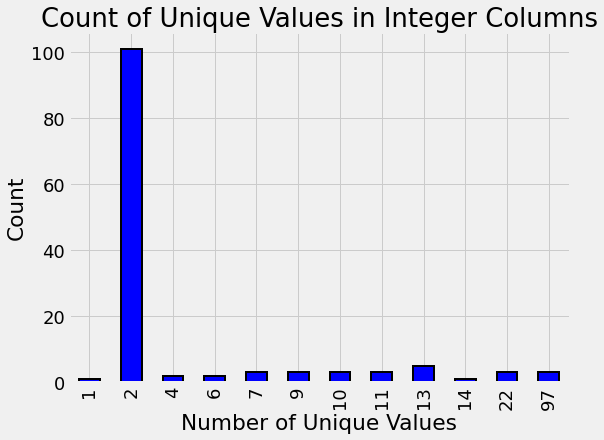

In [202]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8,6), 
                                                                             edgecolor = 'k', 
                                                                             linewidth = 2);
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')
# nunique() unique 값의 개수

두 개의 고유 값만 있는 columns은 Booleans(0 또는 1)을 나타낸다. 많은 경우, Boolean 정보는 이미 가정 level에 있다. 예를들어, `refrig` column은 가정에 냉장고(refrigerator) 유무를 말하고 있다. 이것은 가정 level에 있는 Boolean columns에서 feature를 만들 때, 우리는 이것들을 종합할 필요가 없을 것이다. 그러나 level에 있는 Bloolean columns들은 aggregate가 필요할 것이다.


**Float Columns**  
또 다른 column type은 연속 변수(continuous variables)로 되어있는 floats이다. 우리는 모든 float columns의 분포를 보여주는 빠른 분포도(quick distribution)를 만들 수 있습니다. 우리는 `OrderedDict`를 poverty level의 색상에 매핑하기위해 사용한다. 왜냐하면 이것은 (일반 파이썬 딕셔너리와 달리) 키와 값이 지정된 순서대로 유지되기 때문이다.

다음 그래프는 `Target` 값에 따라 색상이 지정된 float columns의 분포를 보여준다. 이러한 그림을 통해, 우리는 가정 poverty level에 따라 variance 분포에 중요한 차이가 있는지 알 수 있다.

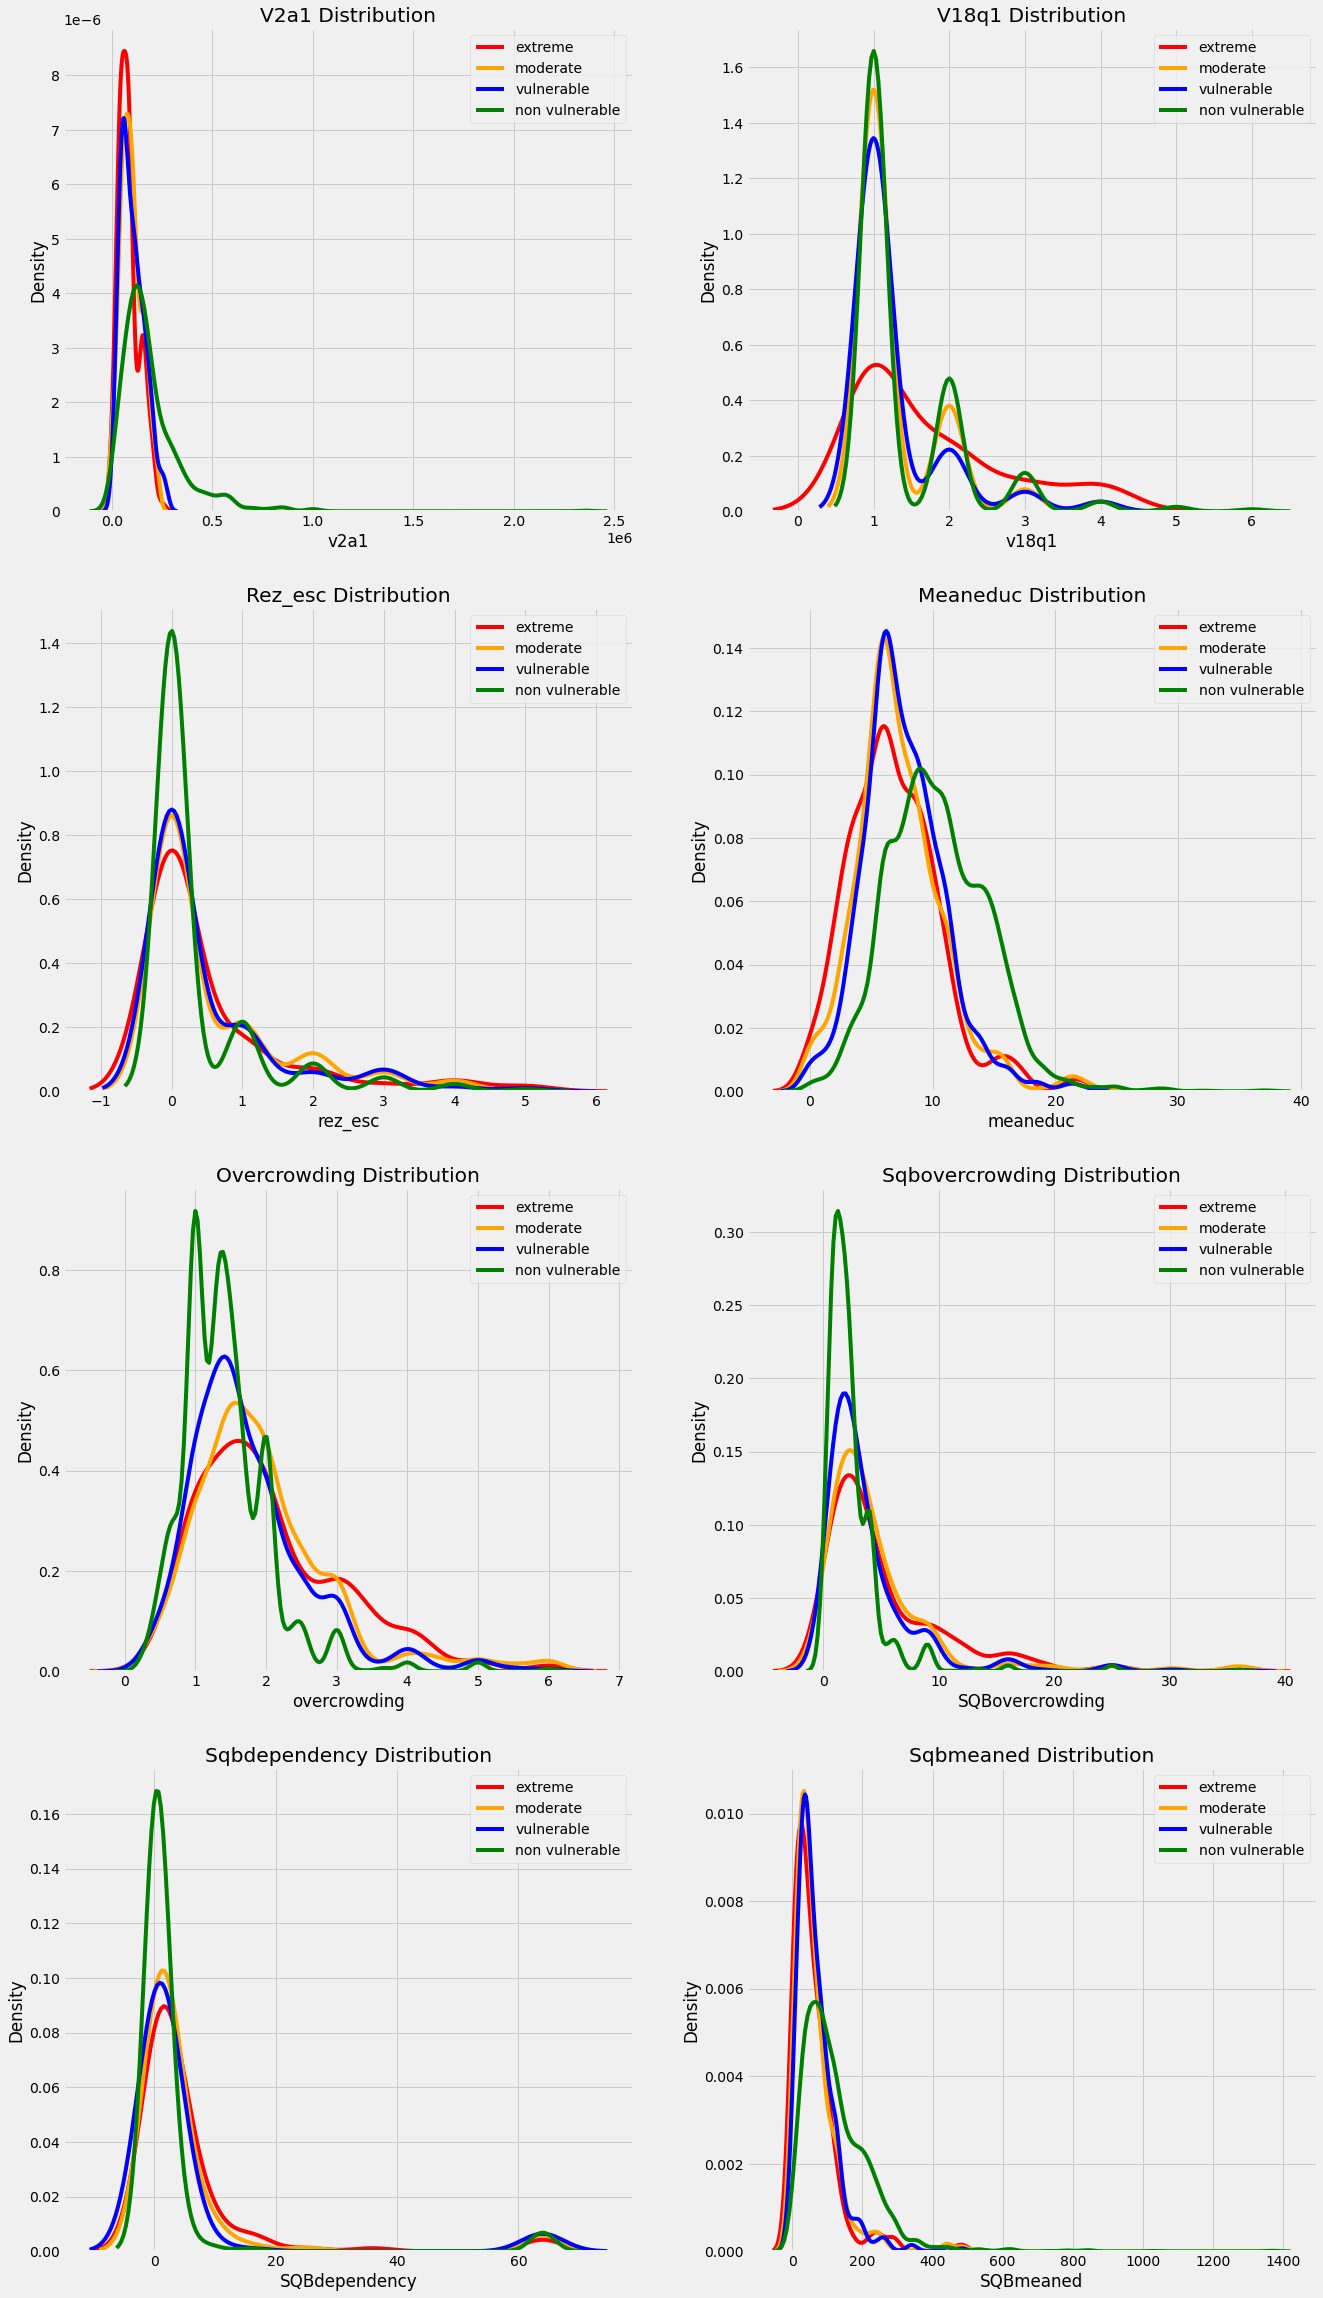

In [203]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2:'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot ezch poverty levle as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                   ax = ax,
                   color = color,
                   label = poverty_mapping[poverty_level])
    
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()
    
plt.subplots_adjust(top = 2)

나중에 우리는 변수와 `Target` 간의 상관 관계를 계산하여 features 간의 관계를 측정하지만, 이러한 그림은 이미 어떤 variables이 모델과 가장 "관련" 있는지 감(sense)을 줄 수 있다. 예를들어, 가정에서 성인 평균 교육을 나타내는 `meaneduc`은  poverty level과 관련있어 보인다: **평균 성인 교육 높을 수록 poverty 정도가 덜한 대상의 값이 높다.** 교육의 중요성에 대한 주제는 우리가 이 노트북에서 몇 번이고 반복할 것이다.

**Object Columns**  
마지막 column type은 아래와 같이 `object`이다.

In [204]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


`Id`와 `Idhogar` object types은 variables을 식별하기 때문에 의미가 있다. 그러나 다른 columns은 기계 학습을 수행하기 전에 해결해야 할 문자열과 숫자의 혼합인 것 같다. 이러한 columns에 대한 설명서(documentation)에 따르면
- `dependency`: 부양가족수 계산 = (19세 미만 가구원 수/64세 이상 가구원 수)/(19세 이상 가구원 수)
- `edjefe`: 남성 가장의 교육 년도, 에스코라리의 관련에 기반으로(교육년도), 가장과 성별, yes=1 and no=0
- `edjefa`: 여성 가장의 교육 년도, 에스코라리의 관련에 기반으로(교육년도), 가장과 성별, yes=1 and no=0

이러한 설명을 통해 문제가 해결된다. 3개의 variables에 따라, **"yes"=1**이고 **"no"=0**이다. 우리는 매핑을 사용하여 variables를 수정하고 floats로 변환할 수 있다.

In [205]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    
train[['dependency', 'edjefe', 'edjefa']].describe()

,dependency,edjefe,edjefa
count,9557.000000,9557.000000,9557.000000
mean,1.149550,5.096788,2.896830
std,1.605993,5.246513,4.612056
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,6.000000,0.000000
75%,1.333333,9.000000,6.000000
max,8.000000,21.000000,21.000000


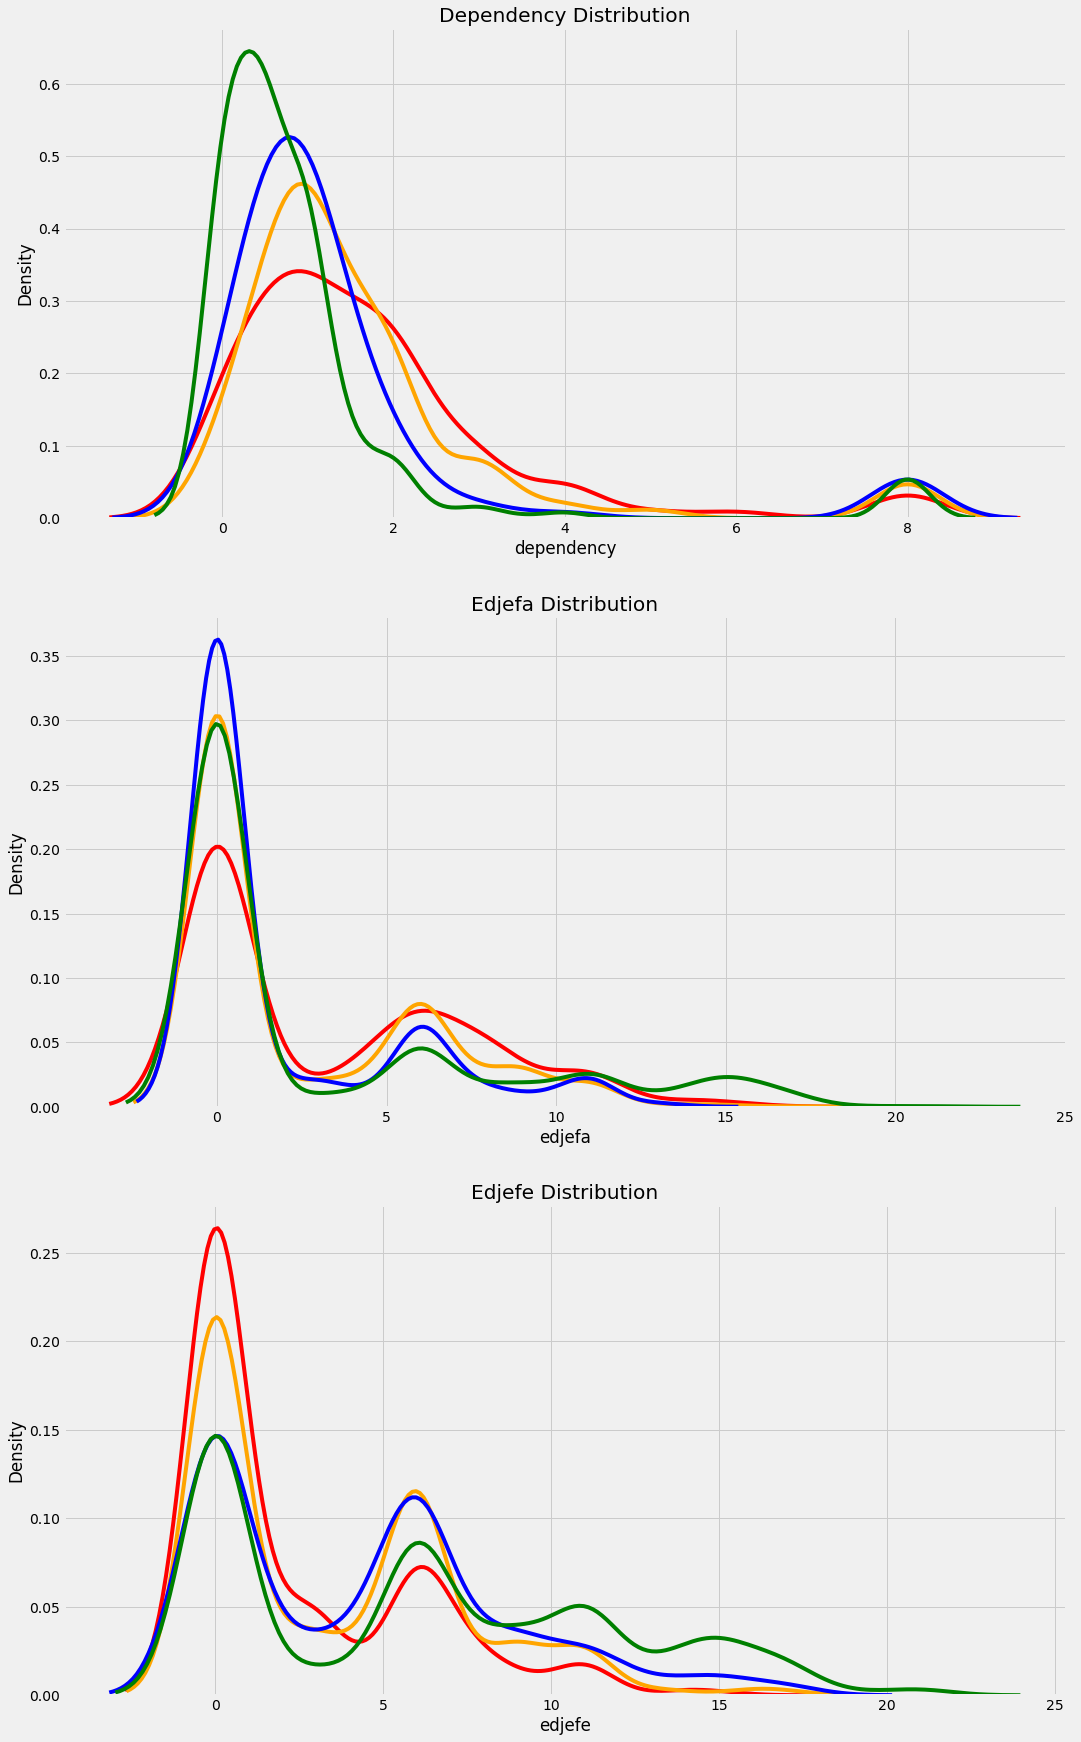

In [206]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i+1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                    ax = ax,
                    color = color,
                    label = poverty_mapping[poverty_level])
    
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    
plt.subplots_adjust(top = 2)

이러한 변수들은 숫자로 올바르게 표현되고 머신러닝 모델에 입력될 수 있다.

위에서와 같은 작업을 좀 더 쉽게 하기 위해서, 우리는 training과 testing dataframes을 모두 합칠 것이다. feature engineering을 수행하면 두 dataframe에 동일한 작업을 적용하하여 동일한 기능을 갖게 되기를 원하기 때문에 이것은 중요하다. 나중에 `Target`을 기반으로 세트를 분리할 수 있다.

In [207]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Exploring Label Distribution
다음으로, 레이블의 분포를 보면 문제가 얼마나 불균형한지 알 수 있습니다. 네 가지 정수 level은 네 가지 다른 poverty level을 나타낸다. 올바른 label을 보기 위해 `parentesco1 == 1`인 column에 대해서만 부분 집합을 취합니다. 이는 각 가정에 대한 올바른 레이블이기 때문입니다.

아래 막대 그림은 test label이 없으므로 train label의 분포를 보여 줍니다.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

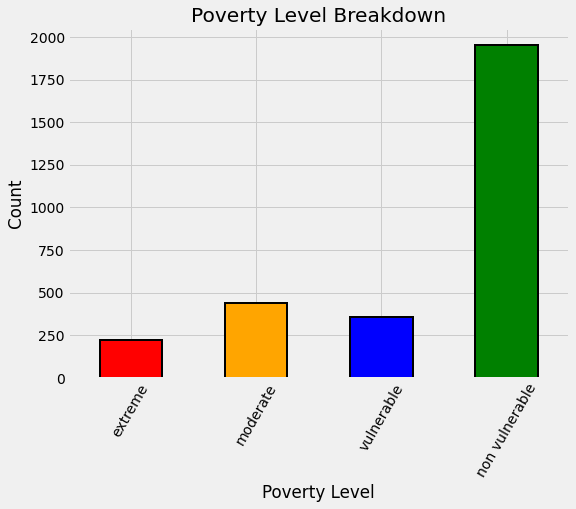

In [208]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6),
                      color = colors.values(),
                      edgecolor = 'k',
                      linewidth = 2)

# Formatting
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown')

label_counts

우리는 불균형 클래스 문제를 다루고 있다(이것은 대회 주최자가 가중치 F1 대신 매크로 F1 점수를 메트릭으로 선택하는 이유를 흥미롭게 만든다!). 취약하지 않은 가정로 분류하는 가정이 다른 어떤 범주보다 훨씬 많다. 극빈층은 가장 작다(나는 이것이 우리를 낙관적으로 만들 것이라고 생각한다!).

불균형 분류 문제의 한 가지 문제는 머신러닝 model이 훨씬 적은 사례를 보기 때문에 소수 클래스를 예측하는 데 어려움을 겪을 수 있다는 것이다. 인간적인 관점에서 생각해볼때: 만약 우리가 극심한 가난보다 가난하지 않는 경우가 훨씬더 많다면, 그것은 우리가 노출이 적기 때문에 높은 가난 가정을 식별하는 것을 더 어렵게 만들 것이다. class imbalanceds를 해결하기 위한 잠재적인 한 가지 방법은 oversampling(더 고급 notebooks에서 커버함)을 사용하는 것 이다.

## Addressing Wrong Labels
다른 현실적인 dataset와 마찬가지로 코스타리카 가난 데이터에도 몇 가지 문제가 있다. 일반적으로 data science project의 80%는 데이터를 cleaning하고 이상 징후/오류를 수정하는데 사용될 것이다. 이런 것들은 인간 입력 오류, 측정 오류 또는 때로는 올바르지만 눈에 띄는 극한값일 수 있다. 이 문제의 경우 몇몇 labels들은 *같은 가구의 개인들이 다른 빈곤 수준을 가지고 있기 때문에* 정확하지 않다. 우리는 왜 이것이 사실(the case)일 수 있는지 말하지 않았지만, 가장을 label(true label)로 삼으라는 말을 들었다.

이 정보는 우리의 작업을 더 쉽게 만들지만, 실제 문제(real-world problem)에서, 우리는 label이 잘못된 이유와 그 문제를 우리 스스로 해결하는 방법을 알아내야 할 것이다. 이 섹션은 label의 문제를 해결하지만 반드시 필요한 것은 아니다: 나는 우리가 이 문제를 어떻게 처리할 수 있는지 보여주기 위해 노트에 보관했다.

### Identify Errors
먼저 오류를 수정하기 전에 오류를 찾아야 한다. 가족 구성원에 대한 label이 다른 가구를 찾기 위해 가구별로 데이터를 그룹화한 다음 `Target`에 고유한 값이 하나만 있는지 확인할 수 있습니다.

In [209]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [210]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최자는 `parentesco1 == 1`인 가구주에 대한 올바른 label이라고 말한다. 이 가정의 경우, 모든 구성원에 대한 올바른 label은 3이다. 우리는 이 가정의 모든 사람들을 올바른 빈곤 수준으로 재할당함으로써 이것을 바로잡을 수 있다. 현실에서는 혼자서 또는 팀의 도움을 받아 문제를 해결하는 방법에 대한 어려운 결정을 내려야 할 수도 있다.

### Families without Heads of Household
우리는 개인들에 가장의 level과 같게 할당하여 모든 label 불일치들을 고칠 수 있다. 하지만 너는 질문이 있을거다. :"만약 가장이 없는 가정이 있다면? 그리고 만약 그 가구들의 구성원들이 라벨에 대한 다른 가치를 가지고 있다면?"

음, 네가 물어봤으니, 정확히 그 질문을 조사해보자!

In [211]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [212]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


다행이다! 이것은 우리가 가장이 없고 구성원들이 label에 대한 다른 값을 가지고 있는 가정에 대해 걱정할 필요가 없다는 것을 의미한다. 주최자에 따르면, 이 문제에 대해, **만약 한 가구가 가장이 있지 않다면, 진정한 label이 없다고 한다. 그러므로, 우리는 실제로 train을 위한 가장이 없는 가정은 사용하지 않을 것이다.** 그럼에도 불구하고, 데이터를 조사하는 이 과정을 거치는 것은 여전히 좋은 연습이다!

### Correct Errors
이제 우리는 가장이 있고 구성원들이 다른 poverty 수준을 가지고 있는 가정에 대한 라벨을 수정할 수 있다.

In [213]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all menbers in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


label에 가장만 사용하기 때문에 **이 단계는 완전히 필요하지 않지만 실제와 같은 데이터 오류를 수정하기 위한 워크플로우를 보여준다.** 추가 업무라고 생각하지 말고, 그냥 경력을 위해 연습하세요!

## Missing Variables
EDA의 가장 중요한 단계중 하나는 데이터에서 missing values를 찾고 이것들을 다룰 방법을 결정하는 것이다. Missing values는 머신러닝 model을 사용하기 전에 채워져야하고 특징 기반으로 채우기 위해 최고의 전략을 생각할 필요가 있다.: 여기서부터 데이터 정의를 조사해야 한다.

먼저 우리는 각 컬럼에서 missing values의 %를 볼 수 있다.

In [214]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


우리는 test data에 대해 'NaN'으로 만들었기 때문에 'Target'에 대해서는 걱정할 필요가 없다. 그러나, 우리는 missing values의 %가 높은 다른 3 columns을 해결할 필요가 있다.

**v18q1**: tablets의 수
가족이 소유한 태블릿의 수를 나타내는 v18q1부터 시작하겠다. 이 variable의 값 개수를 살펴볼 수 있다. 이것은 가정 변수이기 때문에 가정 차원에서 봐야 의미가 있기 때문에 가장에 대한 row만 선택하도록 하겠습니다.

**Function to Plot Value Counts**
서로 다른 column에 대한 값 수를 표시하려고 할 수 있으므로 간단한 함수를 작성할 수 있다!

In [215]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                  edgecolor = 'k',
                                                  linewidth = 2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} Value Counts')
    plt.ylabel(f'Count')
    plt.show()

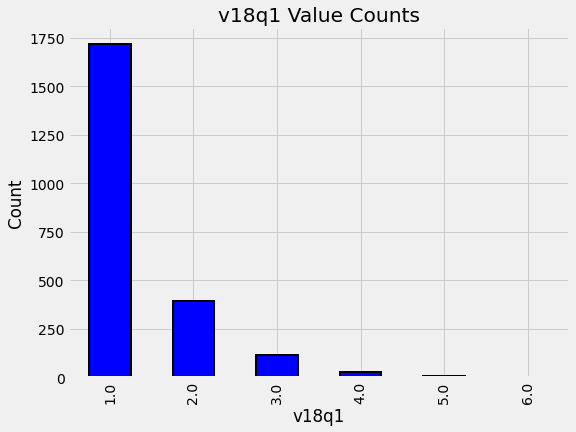

In [216]:
plot_value_counts(heads, 'v18q1')

존재하는 데이터만 기준으로 한다면 태블릿의 가장 일반적인 수는 1개인 것 같다. 그러나, 우리는 또한 결측된 값에 대해 생각할 필요가 있다. 이 경우, 이 범주에 속하는 `nan`을 가진 가족들이 태블릿을 소유하지 않는 것일 수 있다! 데이터 정의를 살펴보면 `v18q`는 가족이 태블릿을 소유하고 있는지 여부를 나타낸다. 우리는 우리의 가설이 타당한지 확인하기 위해 이 column을 태블릿의 수와 결합해서 조사해야 한다.

우리는 `v18q`(태블릿을 소유하는 경우 1이고 그렇지 않은 경우 0)값으로 그룹화한 다음 `v18q1`의 null 값 수를 계산할 수 있습니다. 이것은 null 값이 가족이 태블릿을 소유하고 있지 않음을 나타내는지를 알려준다.

In [217]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

자, 이것으로 문제가 해결됬다. `v18q1`에 `nan`을 가진 모든 가족은 태블릿을 소유하지 않는다. 따라서 missing values를 0으로 채울 수 있다.

In [218]:
data['v18q1'] = data['v18q1'].fillna(0)

**v2a1**: 월세 지불
다음 결측 column은 월세 지불을 나타내는 `v2a1`이다.

월세 지불 missing values를 보는것에 추가로, 주택의 소유/임대 현황을 보여주는 `tipovivi_`의 분폴도 살펴 보는 것은 흥미로울 것이다. 이 그림을 위해, 우리는 월세 지불에 `nan`이 있는 주택의 소유 현황을 보여준다.

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

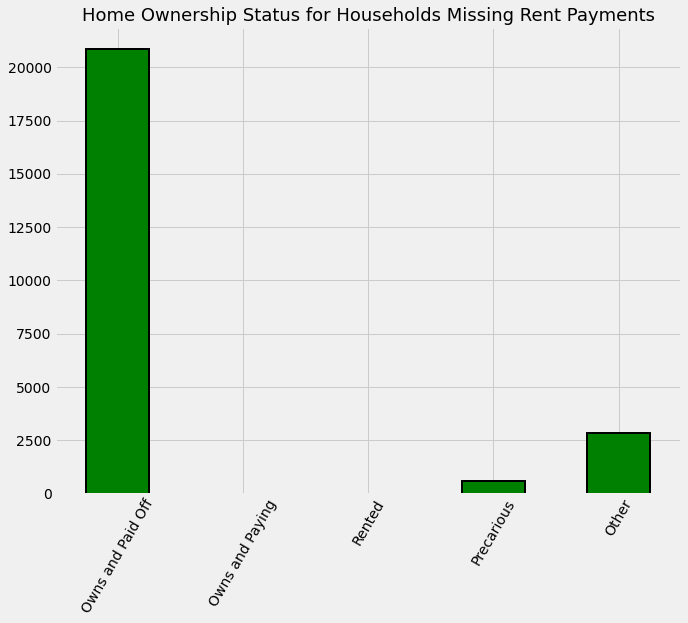

In [219]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                              color = 'green',
                                                              edgecolor = 'k',
                                                              linewidth = 2)
plt.xticks([0, 1, 2, 3, 4], ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
           rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18)

주택 소유 변수의 의미는 다음과 같다.
```
tipovivi1, =소유의 완전 유료 주택
tipovivi2, =1개 소유, 분할 지불
tipovivi3, =1 임대
tipovivi4, =1 불안정
tipovivi5, =1개의 다른 것(예: 차용)
```
문제를 해결했다! 음, 대부분: 월세를 내지 않은 가정은 일반적으로 자신의 집을 소유하고 있다. 다른 몇 가지 상황에서는 정보가 누락된 이유를 알 수 없다.

월세 납부가 누락된 소유 주택에 대해서는 임대료 납부를 0으로 설정할 수 있다. 다른 가정의 경우 missing value을 보정시킬 수 있지만 이러한 가구가 missing values을 가졌다는 것을 나타내는 플래그(boolean) 열을 추가한다.

In [220]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

**rez_esc**: 학교에서 몇 년 뒤처짐
missing values의 %가 가장 높은 마지막 column은 `rez_esc`로 학교생활에서 몇 년 뒤쳐졌음을 나타낸다. null 값을 가진 가정은 경우 현재 학교에 자녀가 없을 수 있다. 이 column에 missing value가 있는 사람의 나이와 missing value가 없는 사람의 나이를 알아봄으로써 이를 검증해 보자.

In [221]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이것이 우리에게 말해주는 것은 missing value를 가진 가장 나이가 많다는 나이는 17살이다. 이것보다 나이가 많은 사람들에게, 우리는 그들이 단순히 학교에 있지 않다고 가정할 수 있다. missing values가 있는 사람들의 나이를 살펴보자.

In [222]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

이 [competition를 위한 토론(discussions for this competition)](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403)의 일부를 읽으면 이 variable는 7세에서 19세 사이의 개인에게만 정의된다는 것을 알게 된다. 이 범위보다 어리거나 나이가 많은 사람은 아마도 연차가 없기 때문에 이 값을 0으로 설정해야 합니다. 이 variable의 경우 개인이 19세 이상이고 missing values가 있는 경우 또는 7세 미만이고 missing values이 있는 경우 0으로 설정할 수 있다. 다른 사용자는 귀속될 값을 남겨 두고 부울 플래그를 추가한다.

In [223]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) & (data['age'] < 7) & (data['rez_esc'].isnull())), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

`rez_esc` column에도 특이치(outlier)가 하나 있다. 다시 한 번 competition discussions을 읽어보면 이 variable의 최대값은 5입니다. 따라서 5보다 큰 값은 5로 설정해야 한다.

In [224]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables
두 categorical variables가 서로 상호 작용하는 방식을 보여주기 위해 scatterplots, faceted bar plots, boxplots 등 여러 가지 표시 옵션이 있다. 나는 이 선택들에 만족하지 못했기 때문에 아래에 함수를 작성했는데, 이것은 본질적으로 점들의 크기가 각 x 값으로 표현되는 주어진 y값의 %을 나타내는 두 범주의 산점도이다.

In [225]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         text = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

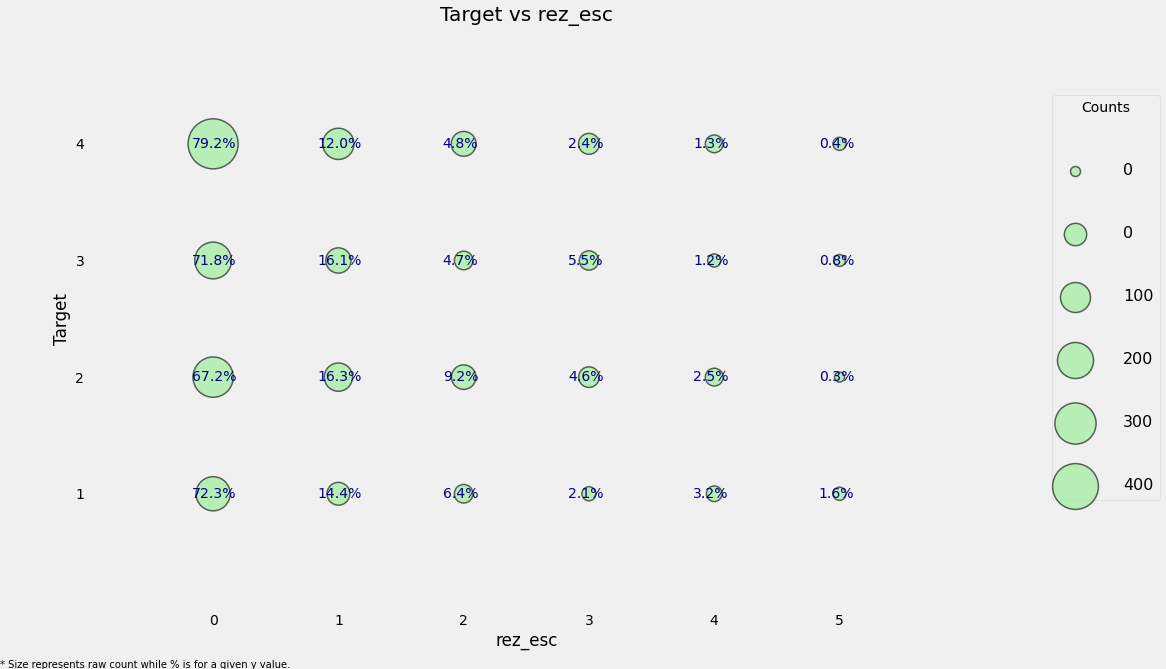

In [226]:
plot_categoricals('rez_esc', 'Target', data);

마커의 크기는 원시 카운트를 나타냅니다. 그림을 읽으려면 지정된 y-값을 선택한 다음 행을 가로질러 읽습니다. 예를 들어, 빈곤 수준이 1,93%인 개인은 약 800명으로 1년 뒤처져 있지 않으며, 약 0.4%의 개인은 약 50명으로 5년 뒤처져 있다. 이 그래프는 전체 카운트와 범주 내 비율을 모두 표시하려고 합니다. 완벽하지는 않지만 시도해 보았습니다!

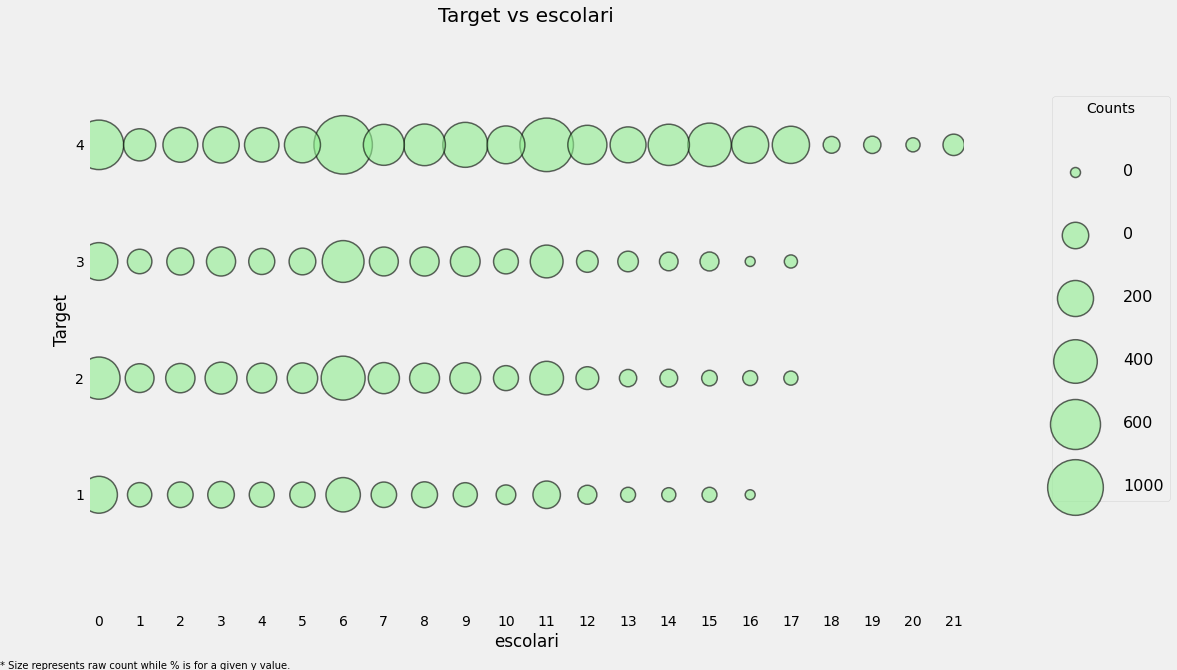

In [227]:
plot_categoricals('escolari', 'Target', data, annotate = False)

각 열의 나머지 결측값이 채워집니다. 이 프로세스를 `Imputation`이라고 합니다. 일반적으로 사용되는 귀속에는 몇 가지 유형이 있으며, 가장 간단하고 효과적인 방법 중 하나는 결측값을 열의 `median`로 채우는 것이다.

결측값이 있는 마지막 단계로 이러한 값 중 하나가 결측된 경우 목표값의 분포를 표시할 수 있습니다.

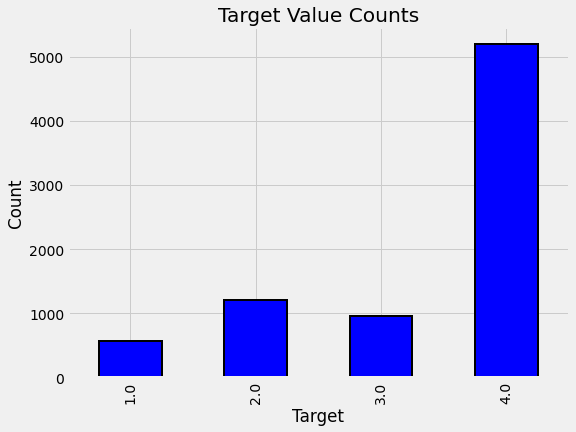

In [228]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

이 분포는 전체 데이터에 대해 일치하는 것으로 보입니다.

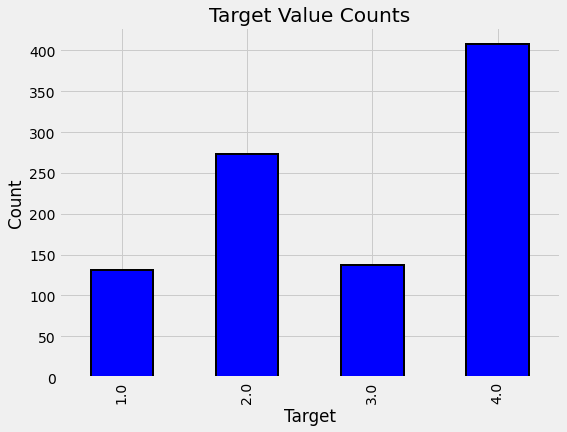

In [229]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

이것은 2의 더 높은 유병률을 고려할 때 더 많은 빈곤을 나타내는 지표가 될 수 있을 것 같다: 중간 정도의 빈곤.

**이것은 중요한 점을 나타냅니다.** 때로는 누락된 정보가 제공된 정보만큼 중요한 경우도 있습니다.

# Feature Engineering
우리가 할 수 있는 탐색적 데이터 분석은 많이 있지만, 먼저 가계 수준에서 데이터를 통합하는 작업을 해야 합니다. 우리는 이미 각 가구에 대한 정보를 일부 가지고 있지만, 훈련을 위해서는 각 가구에 대해 요약된 모든 정보가 필요할 것이다. 즉, 주택의 개인을 그룹화(`groupby`)하고 개별 변수의 집계(`agg`)를 수행하는 것을 의미합니다.

다른 노트북에서는 자동 기능 엔지니어링을 사용하여 이를 수행하는 방법을 보여주며, **자동 기능 엔지니어링**은 기계 학습 워크플로우의 표준 부분이 되어야 한다. 지금 당장은 손으로 직접 이 작업을 수행하겠지만 **FeatureTools의 자동화된 기능 엔지니어링**을 반드시 살펴보십시오.

## Column Definitions
때때로 데이터 과학에서 우리는 데이터를 조사하거나 많은 시간이 걸리는 지루한 작업을 해야 한다. 이것은 분석의 일부입니다. 우리는 데이터 설명을 사용하여 개별 수준과 가구 수준에 있는 열을 정의해야 합니다. 데이터 설명에서 변수 자체를 살펴보는 것 외에 가구 수준에서 어떤 변수가 있는지 식별하는 다른 방법은 없다. 내가 이미 해줬으니까 복사해서 붙이기만 하면 돼!

일부 변수를 다른 방식으로 처리해야 하므로 다른 변수를 정의합니다. 각 수준에서 정의된 변수가 있으면 필요에 따라 집계 작업을 시작할 수 있습니다.

그 과정은 다음과 같다.

1. 변수를 가구 수준과 개인 수준으로 구분
2. 개별 수준 데이터에 적합한 집계 찾기
 - 순서형 변수는 통계 집계를 사용할 수 있습니다.
 - 부울 변수도 집계할 수 있지만 통계량은 더 적습니다.
3. 개별 집계를 가구 수준 데이터에 결합

### Define Variable Categories
변수에는 몇 가지 다른 범주가 있습니다.

1. 개별 변수: 이는 가구가 아닌 각 개인의 특성입니다.
 - 부울: 예 또는 아니오(0 또는 1)
 - 순서 이산형: 순서가 있는 정수
2. 가계 변수
 - 부울: 예 또는 아니오
 - 순서 이산형: 순서가 있는 정수
 - 연속 숫자
3. 변수 제곱: 데이터의 제곱 변수에서 파생됨
4. ID 변수: 데이터를 식별하므로 피쳐로 사용해서는 안 됩니다.

아래에서는 각 범주의 변수를 수동으로 정의합니다. 이것은 조금 지루하지만 또한 필요하다.

In [230]:
id_ = ['Id', 'idhogar', 'Target']

In [231]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [232]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [233]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

모든 변수를 다루었고 반복하지 않았는지 확인합시다.

In [234]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])


There are no repeats:  True
We covered every variable:  True


**Squared Variables**  
먼저, 가장 쉬운 단계입니다. 모든 제곱 변수를 제거할 것입니다. 선형 모델이 비선형 관계를 학습하는 데 도움이 되기 때문에 때때로 변수는 feature engineering의 일부로 제곱되거나 변환됩니다. 그러나, 우리는 더 복잡한 모델을 사용할 것이기 때문에, 이러한 제곱 기능은 중복된다. 그것들은 제곱되지 않은 버전과 높은 상관 관계가 있으므로 관련 없는 정보를 추가하고 훈련 속도를 늦춤으로써 실제로 우리 모델을 해칠 수 있다.

예를 들어, `SQBage` vs `age`을 살펴보겠습니다.

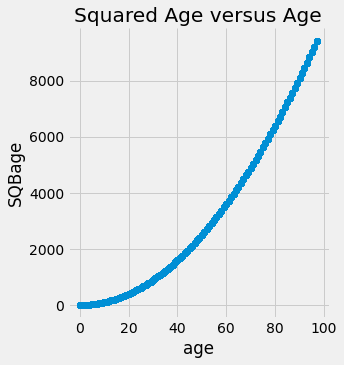

In [235]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

이 변수들은 상관관계가 매우 높기 때문에 두 변수 모두를 데이터에 저장할 필요가 없습니다.

In [236]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

## Id Variables
이것들은 매우 간단합니다. 신원 확인을 위해 필요하기 때문에 데이터에 있는 그대로 유지됩니다.
## Household Level Variables
먼저 가장에 부분집합한 다음 가구 수준 변수에 대해 부분집합을 해보자.

In [237]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

대부분의 가구 수준 변수에 대해, 우리는 그것들을 단순히 그대로 유지할 수 있다: 우리는 각 가구에 대해 예측을 하고 싶기 때문에, 우리는 이 변수들을 특징으로 사용한다. 그러나 일부 중복 변수를 제거하고 기존 데이터에서 파생된 기능을 추가할 수도 있습니다.

### Redundant Household Variables
모든 가계 변수 간의 상관관계를 살펴보겠습니다. 상관 관계가 너무 높은 변수가 있으면 상관 관계가 높은 변수 쌍 중 하나를 제거할 수 있습니다.

다음 코드는 절대 등급 상관 관계가 0.95보다 큰 변수를 식별합니다.

In [238]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

각 상관 변수 쌍 중 하나를 표시합니다. 다른 쌍을 찾기 위해, 우리는 `corr_matrix`를 부분집합할 수 있다.

In [239]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


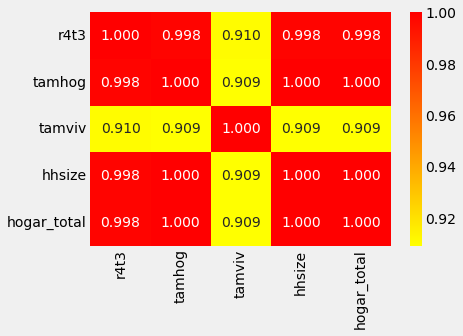

In [240]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

여기에는 집의 크기와 관련된 몇 가지 변수가 있다.

- r4t3, 총 가구원
- tamhog, 가족의 크기
- tamviv, 가구에 거주하는 사람 수
- hhsize, 가구 크기
- hogar_total, 가구 내 총인원 수

이 변수들은 모두 서로 높은 상관 관계가 있습니다. 사실, `hhsize`는 `tammog`와 `hogar_total`과 완벽한 상관관계를 가지고 있다. 정보가 중복되기 때문에 우리는 이 두 변수를 제거할 것이다. 또한 `r4t3`는 `hhsize`와 거의 완벽한 상관관계가 있기 때문에 제거할 수 있습니다.

`tamviv`는 가정에 살지 않는 가족이 있을 수 있기 때문에 반드시 `hhsize`와 동일하지는 않다. 이 차이를 산점도에서 시각화해 보겠습니다.

In [241]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

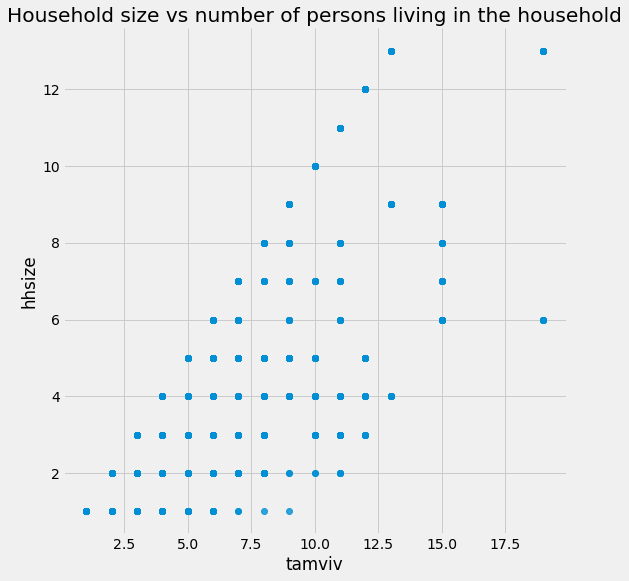

In [242]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

우리는 많은 경우에, 가족보다 더 많은 사람들이 살고 있다는 것을 알 수 있다. **이 두 측정값의 차이**인 새로운 기능에 대한 좋은 아이디어를 제공합니다!

이 새로운 feature을 만들어 봅시다.

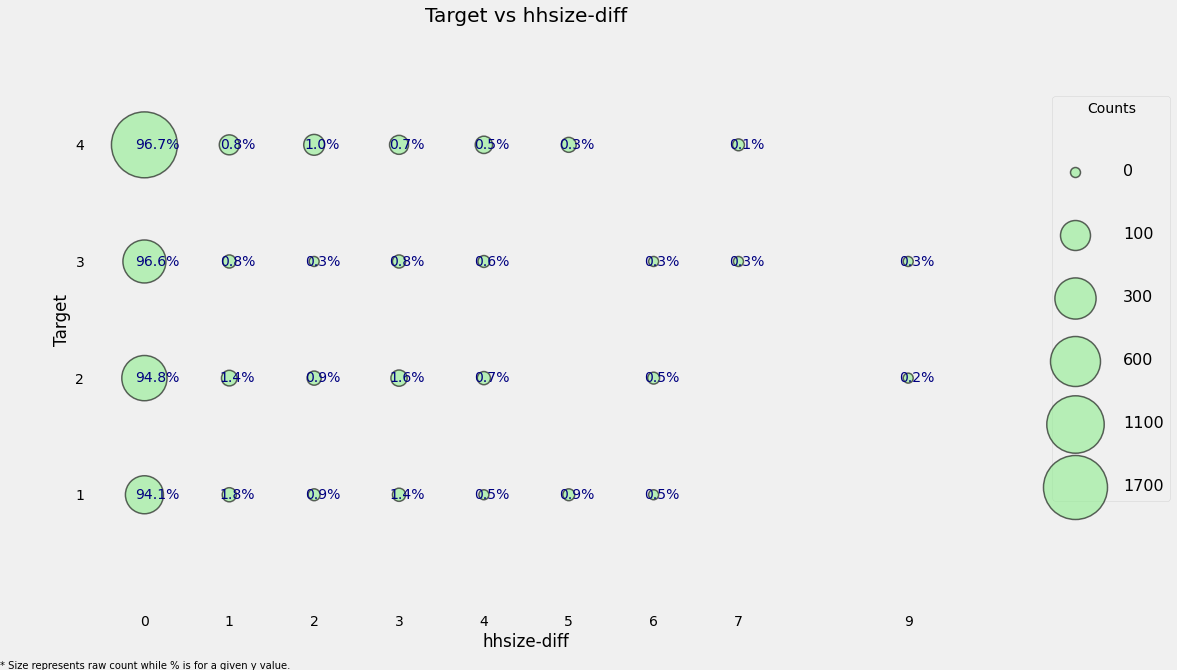

In [243]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

대부분의 가구가 차이가 없더라도 가구원보다 더 많은 사람이 살고 있는 경우도 있다.

이제 다른 중복 변수로 넘어갑시다. 먼저 우리는 `coopele`을 볼 수 있다.

In [244]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수들은 가정의 전기가 어디에서 오는지 나타냅니다. 네 가지 옵션이 있으며, 이 두 가지 옵션 중 하나가 없는 가정은 전기(`noelec`)가 없거나 민간 공장(`planpri`)에서 공급받습니다.

**Creating Ordinal Variable**  
순서형 변수를 만들어 이 네 가지 변수를 하나로 압축해 보겠습니다. 데이터 설명에 따라 직접 매핑을 선택합니다.
```
0: 전기가 들어오지 않음
1: 협동조합의 전기
2: CNFL, ICA, ESPH/JASEC의 전기
3: 개인 발전소에서 나오는 전기
```
순서형 변수는 고유한 순서가 있으며, 이를 위해 우리는 도메인 지식을 기반으로 자체 순서를 선택한다. 이 새로운 순서 변수를 만든 후에 나머지 4개를 삭제할 수 있습니다. 여기에 변수가 없는 가구가 여러 개 있으므로 `nan`(귀속 중에 채워질 것)을 사용하고 이 변수에 대한 측도가 없음을 나타내는 Boolean 열을 추가합니다.

In [245]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

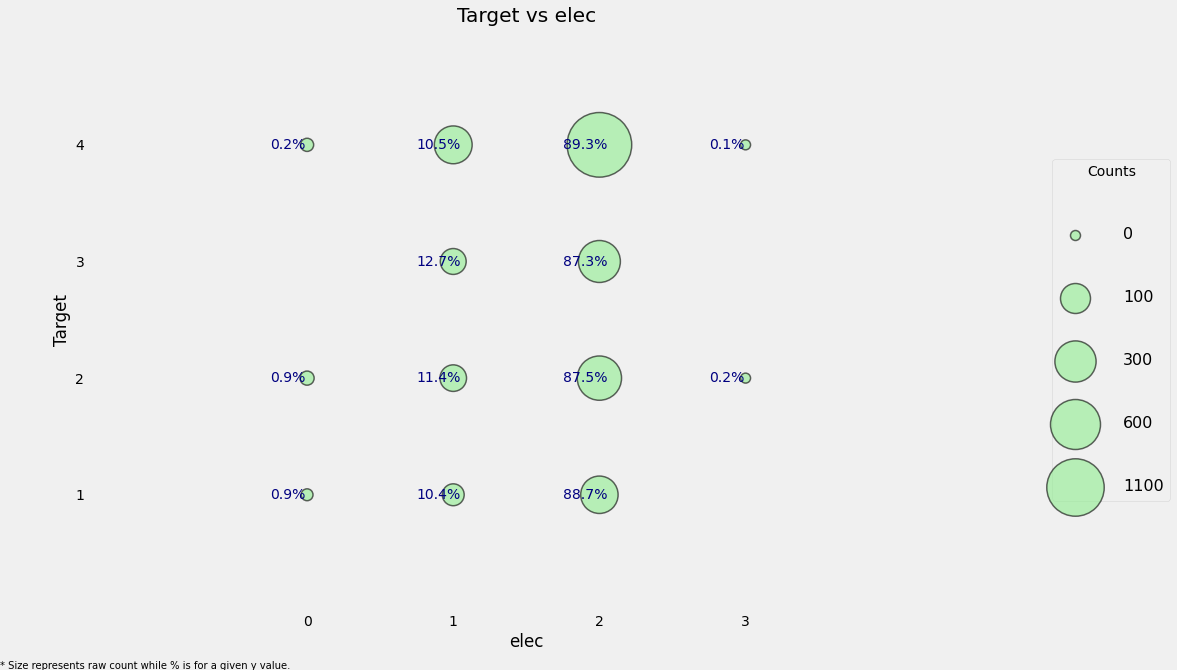

In [246]:
plot_categoricals('elec', 'Target', heads)

Target의 모든 값에 대해 가장 일반적인 전력 공급원은 나열된 공급자 중 하나임을 알 수 있습니다.

마지막 중복 열은 영역 2입니다. 이것은 그 집이 시골 지역에 있다는 것을 의미하지만, 우리는 그 집이 도시 지역에 있는지 나타내는 칸이 있기 때문에 중복됩니다. 따라서 이 열을 삭제할 수 있습니다.

In [247]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시 지역 가구(값 1)가 농촌 지역 가구(값 0)보다 빈곤 수준이 낮을 가능성이 더 높은 것으로 보입니다.

### Creating Ordinal Variables
집의 벽, 지붕, 바닥은 각각 세 개의 기둥이 있는데, 첫 번째 기둥은 '나쁨', 두 번째 기둥은 '보통', 세 번째 기둥은 '좋음'이다. 변수를 불변으로 남겨둘 수도 있지만, 나에게는 순서형 변수로 바꾸는 것이 더 이치에 맞다. 왜냐하면 내재된 순서가 있기 때문이다: `bad < regular < good`. 이를 위해 `np.argmax`를 사용하여 각 가구에 대해 0이 아닌 열을 쉽게 찾을 수 있습니다.

순서 변수를 만들면 원래 변수를 삭제할 수 있습니다.

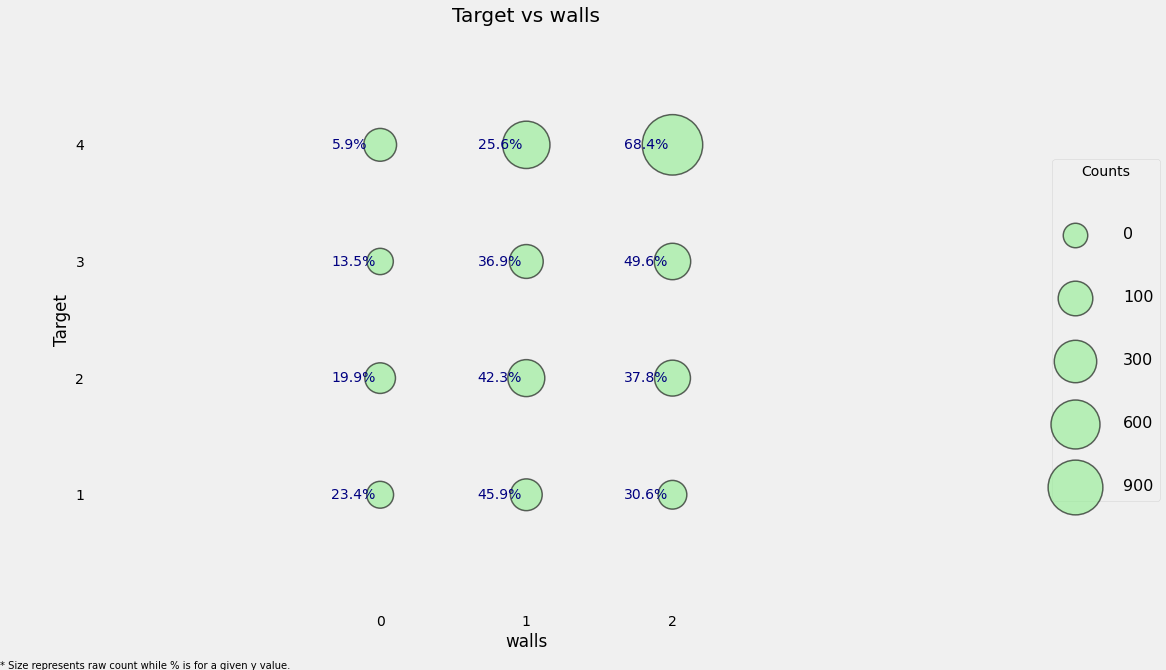

In [248]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [249]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Feature Construction
변수를 순서 features에 매핑하는 것 외에도 features 구성이라고 알려진 기존 데이터에서 완전히 새로운 형상을 만들 수도 있다. 예를 들어, 우리는 방금 만든 세 가지 특징을 합산하여 집의 구조의 질을 전반적으로 측정할 수 있습니다.

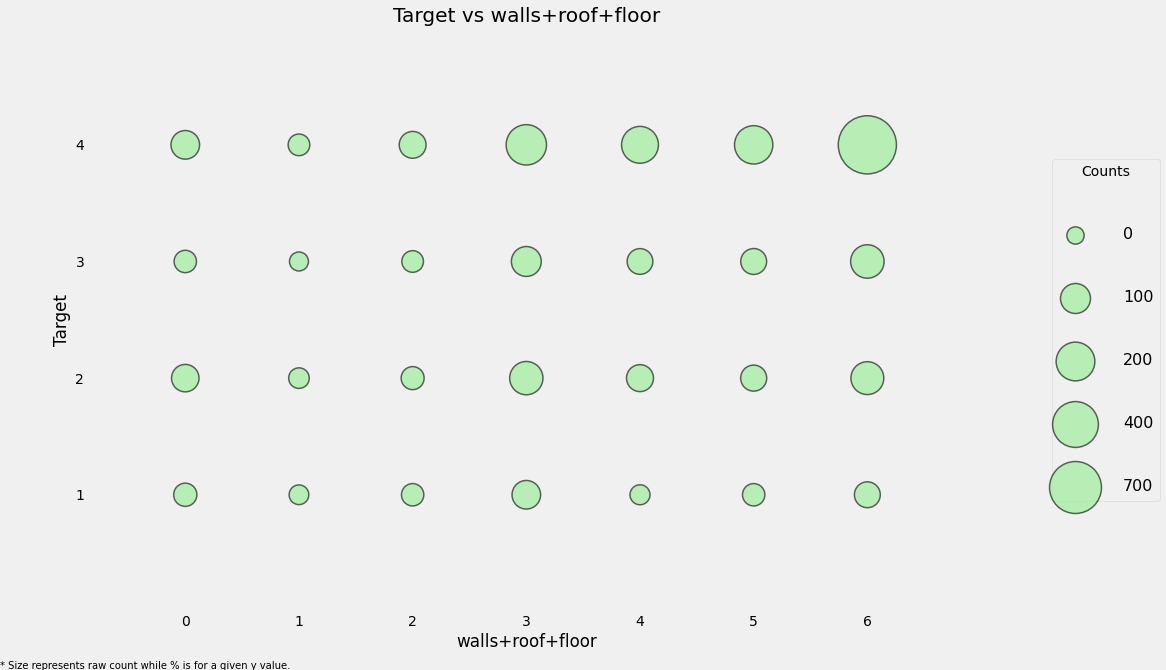

In [250]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

이 새로운 기능은 목표값 4(최저 빈곤 수준)가 '주택 품질' 변수의 값이 더 높은 경향이 있기 때문에 유용할 수 있습니다. 우리는 또한 이것을 표에서 볼 수 있고 세밀한 세부 사항들을 얻을 수 있다.

In [251]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


다음 변수는 집의 질에 대한 `경고`가 될 것이다. 화장실, 전기, 바닥, 수도, 천장이 없는 경우 각각 -1점으로 마이너스 값이 됩니다.

In [252]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

우리는 이러한 관계를 시각화하기 위해 `plot_categoricals` 함수를 계속 사용할 수 있지만, `seaborn`은 범주형에서 작동할 수 있는 많은 플롯 옵션도 가지고 있다. 하나는 y 축에 있는 변수의 분포를 해당 범주의 관측치 수를 나타내는 각 그래프의 너비로 표시하는 `violinplot`입니다.

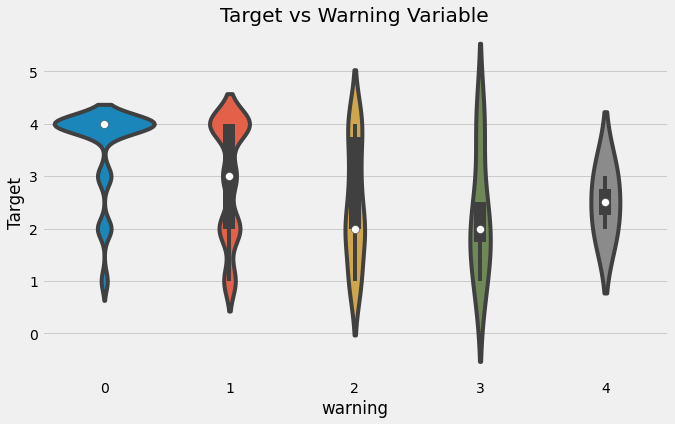

In [253]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

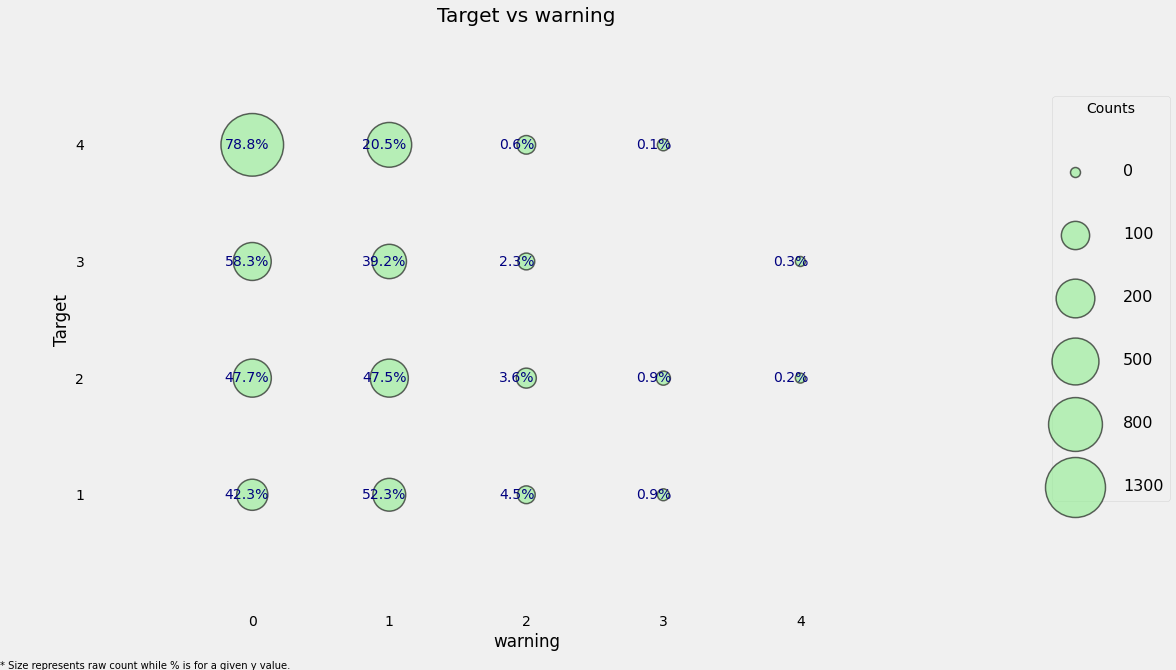

In [254]:
plot_categoricals('warning', 'Target', data = heads)

`violinplot`은 대상이 실제보다 더 작고 큰 값을 가질 수 있는 것처럼 보이는 효과로 범주형 변수를 매끄럽게 만들기 때문에 여기서 훌륭하지 않다. 그럼에도 불구하고, 우리는 경고 신호가 없고 빈곤 수준이 가장 낮은 가구의 높은 집중도를 볼 수 있다. 이것이 유용한 기능인 것처럼 보이지만, 모델링을 시작하기 전에는 확실히 알 수 없습니다!

현재 우리가 만들 수 있는 마지막 가정용 기능은 가족이 냉장고, 컴퓨터, 태블릿 또는 텔레비전을 가질 때 포인트를 얻는 보너스이다.

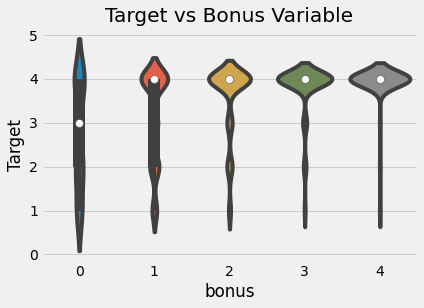

In [255]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

## Per Capita Features
우리가 만들 수 있는 추가적인 특징들은 가구 내 각 인원에 대한 특정 측정의 수를 계산한다.

In [256]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables
기능을 정리하는 데 많은 노력을 기울인 후 이제 Target과 관련하여 기능을 살펴볼 수 있습니다. 우리는 이미 이것을 조금 했지만, 이제 관계를 정량화할 수 있습니다.

### Measuring Relationships
두 변수 간의 관계를 측정하는 방법에는 여러 가지가 있습니다. 여기서는 다음 두 가지를 살펴보겠습니다.
1. Pearson 상관 관계: 두 변수 사이의 선형 관계를 측정하는 -1부터 1까지
2. Spearman 상관 관계: 두 변수 사이의 단조로운 관계를 측정하는 -1부터 1까지
한 변수가 증가하면 관계가 선형적이지 않더라도 다른 변수도 증가하면 Spearman 상관관계는 1입니다. 반면에 Pearson 상관관계는 증가가 정확히 선형인 경우에만 1이 될 수 있습니다. 이것들은 예시로 가장 잘 설명된다.

In [257]:
from scipy.stats import spearmanr

In [258]:
def plot_corrs(x, y):
    """Plot data and show the spearman and pearson correlation."""
    
    # Calculate correlations
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    # Scatter plot
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure( figsize = (6, 4))
    sns.regplot('x', 'y', data = data, fit_reg = False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

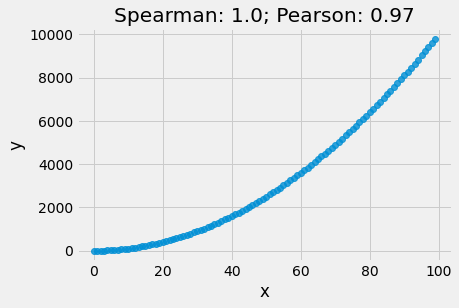

In [259]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

Spearman 상관관계는 종종 Target이나 교육 연도와 같은 순서 변수에 더 낫다고 여겨진다. 현실 세계의 대부분의 관계는 선형적이지 않으며 Pearson 상관관계는 두 변수의 상관관계를 근사적으로 나타낼 수 있지만 정확하지 않으며 최상의 비교 방법은 아닙니다.

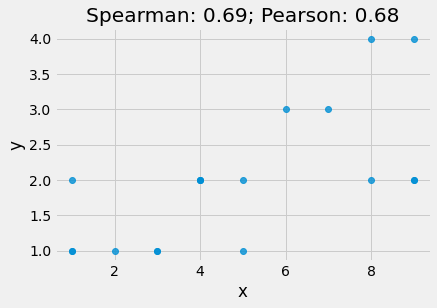

In [260]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

대부분의 경우 값이 매우 유사합니다.

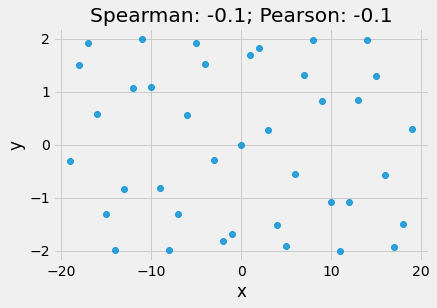

In [261]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)

먼저 Target과의 모든 변수의 Pearson 상관 관계를 계산합니다.

In [262]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('Most positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908
Most positively correlated variables:
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


음의 상관관계의 경우, 변수를 늘리면 대상이 감소하여 빈곤의 심각성이 증가함을 나타냅니다. 그러므로, 경고가 증가할수록, 빈곤 수준도 증가하는데, 이는 이것이 집에 대한 잠재적인 나쁜 징후를 보여주기 위한 것이었기 때문에 이치에 맞다. `hogar_nin `은 가족 내 0 - 19명의 자녀 수를 의미하기도 한다: 어린 아이들은 더 높은 수준의 빈곤으로 이어지는 가족에게 재정적인 스트레스 요인이 될 수 있다. 또는 사회경제적 지위가 낮은 가정은 그들 중 한 명이 성공할 수 있을 것이라는 희망으로 더 많은 자녀를 두고 있다. 설명이 무엇이든 간에, 가족의 규모와 빈곤 사이에는 진정한 연관성이 있다.

반면에 양의 상관관계에 있어서, 값이 클수록 빈곤의 심각성이 감소한다는 것을 나타내는 Target값이 높다는 것을 의미한다. 가장 높은 상관관계가 있는 가구 수준 변수는 가구 내 성인의 평균 교육 수준인 평균 교육이다. 교육과 빈곤 사이의 이러한 관계는 직관적으로 타당하다: 더 높은 수준의 교육은 일반적으로 더 낮은 수준의 빈곤과 관련이 있다. 우리는 어떤 원인이 같은 방향으로 움직이는지 반드시 알 수는 없지만, 하지만 우리는 이것이 같은 방향으로 움직이는 경향이 있다는 것을 알고 있습니다.

다음은 상관 값에 대한 일반적인 지침이지만, 누구에게 요청하느냐에 따라 달라집니다(이러한 값에 대한 [출처](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf)).
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

이러한 상관관계가 보여주는 것은 우리 모델이 features에서 Target에 대한 매핑을 학습하는 데 사용할 수 있는 몇 가지 약한 관계가 있다는 것이다.

이제 Spearman 상관관계로 넘어갈 수 있습니다.

In [263]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

Spearman 상관 계수 계산에는 관계의 유의 수준을 나타내는 p값도 함께 제공됩니다.  0.05보다 작은 p값은 일반적으로 유의한 것으로 간주되지만, 다중 비교를 수행 중이므로 p값을 비교 수로 나누려고 합니다. 이 과정을 Bonferroni 보정이라고 합니다.

In [264]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('Most positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33
Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


대부분의 경우, 상관 관계를 계산하는 두 가지 방법은 일치합니다. 단지 호기심에서, 우리는 가장 멀리 떨어져 있는 값들을 찾을 수 있다.

In [265]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [266]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


상관관계에서 가장 큰 불일치는 `dependency `이다. `target` 대 `dependency `에 대한 산점도를 만들어 관계를 시각화할 수 있습니다. 그래프에 지터를 약간 추가합니다. 둘 다 이산형 변수이기 때문입니다.

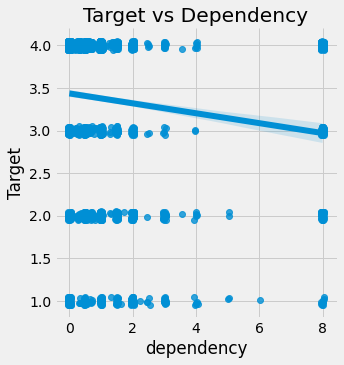

In [267]:
sns.lmplot('dependency', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Dependency');

관계를 확인하기는 어렵지만 약간 부정적입니다. `dependency`가 증가함에 따라 `Target` 값이 감소합니다. 이것은 일리가 있다: `dependency`는 의존적인 개인의 수를 비의존적인 사람의 수로 나눈 것이다. 이 값이 높아질수록 빈곤의 심각성은 증가하는 경향이 있다: 더 많은 의존적인 가족 구성원(일반적으로 비직장인)은 비의존적인 가족 구성원의 지원을 받아야 하기 때문에 더 높은 수준의 빈곤으로 이어진다.

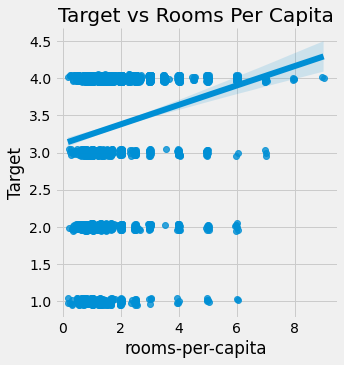

In [268]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

**Correlation Heatmap**  
제가 가장 좋아하는 그림 중 하나는 heatmap입니다. 왜냐하면 그것은 하나의 이미지에 엄청난 양의 정보를 보여주기 때문입니다. heatmap의 경우 7개의 변수를 선택하고 변수와 목표값 간의 상관 관계를 보여 줍니다.

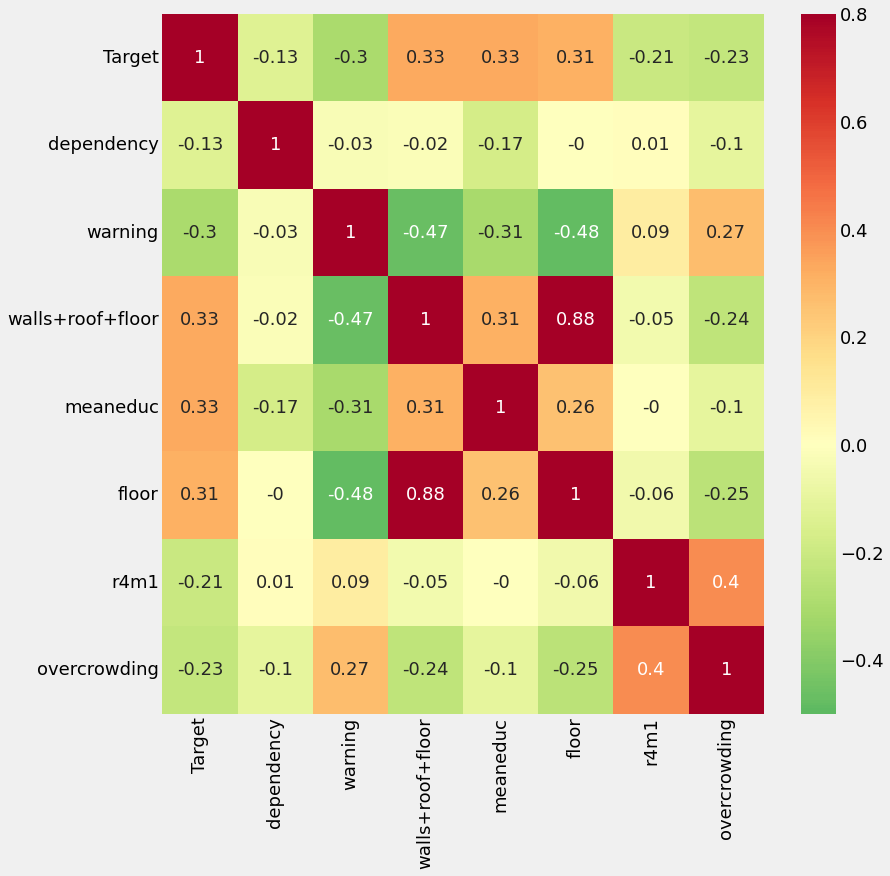

In [269]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

이 그래프를 보면 `Target`과 상관 관계가 약한 변수가 여러 개 있음을 알 수 있습니다. 또한 공선성으로 인해 문제가 될 수 있는 일부 변수(예: `floor` 및 `walls+roof+floor`) 사이에는 높은 상관 관계가 있습니다.

### Features Plot
가구 수준 데이터의 최종 탐색을 위해 Target과 가장 상관관계가 높은 변수 중 일부를 그림으로 표시할 수 있습니다. 위쪽 삼각형의 산점도, 대각선의 커널 밀도 추정치(kde) 그림, 아래쪽 삼각형의 2D KDE 그림이 표시됩니다.

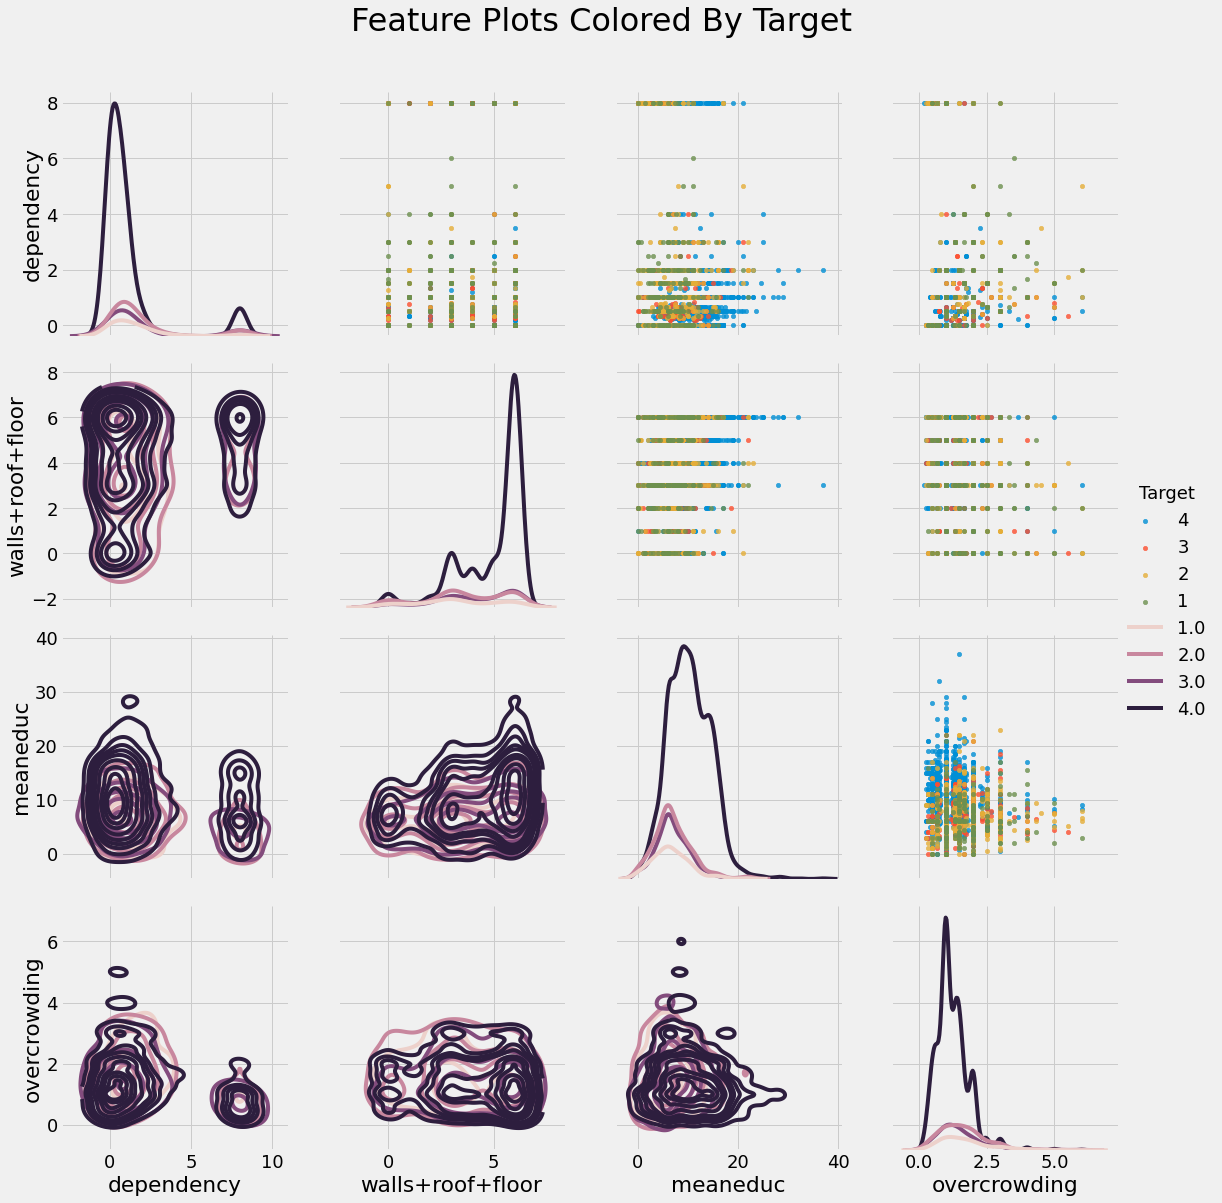

In [270]:
import warnings
warnings.filterwarnings('ignore')

# Copy the data for plotting
plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey=False,
                    hue = 'Target', hue_order = [4, 3, 2, 1], 
                    vars = [x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

가정변수의 feature engineering을 일단 남겨두겠습니다. 나중에 모델 성능이 마음에 들지 않으면 이 단계로 돌아갈 수 있습니다.

In [271]:
household_feats = list(heads.columns)

# Individual Level Variables
두 가지 유형의 개별 수준 변수가 있습니다. 부울(참 또는 거짓의 경우 1 또는 0) 및 순서(의미 있는 순서가 있는 개별 값)입니다.

In [272]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant Individual Variables
가구 수준 변수와 동일한 프로세스를 수행하여 중복 개별 변수를 식별할 수 있습니다. 상관 계수의 절대 크기가 0.95보다 큰 변수에 초점을 맞출 것입니다.

In [273]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

이것은 단순히 남성의 반대입니다! 우리는 남자 flag을 제거할 수 있다.

In [274]:
ind = ind.drop(columns = 'male')

### Creating Ordinal Variables
가구 수준 데이터를 사용한 것처럼 기존 열을 순서형 변수에 매핑할 수 있습니다. 여기서는 `instlevel_`변수에 초점을 맞추는데, `instlevel_`변수는 `instlevel1`: no education level에서 `instlevel9`: 대학원 education까지 개인의 교육량을 나타낸다.

각 개인에 대해 순서 변수를 생성하기 위해, 우리는 단순히 어떤 열이 0이 아닌지를 찾을 것이다. 교육은 고유한 순서(높을수록 더 좋다)를 가지고 있으므로 이러한 순서형 변수로의 변환은 문제의 맥락에서 의미가 있습니다.

In [275]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


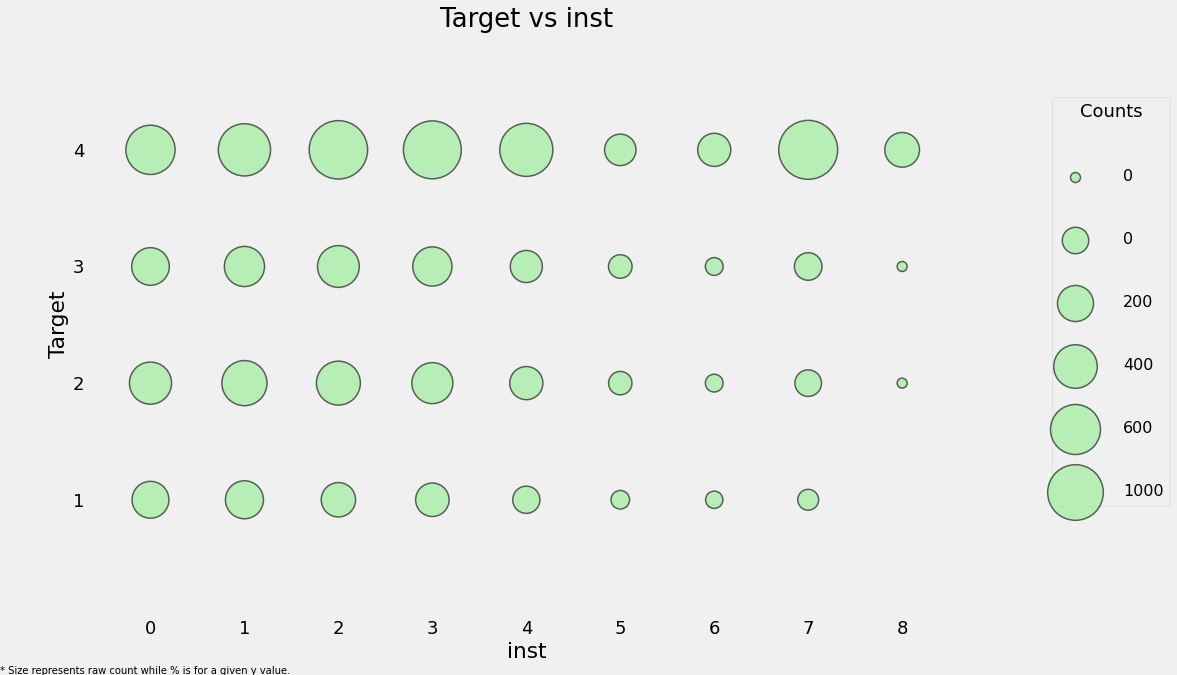

In [276]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False);

높은 교육 수준은 덜 극단적인 빈곤 수준에 해당하는 것 같다. 그러나 우리는 이것이 개별적인 수준이라는 것을 명심해야 할 필요가 있고 우리는 결국 가구 수준에서 이 데이터를 집계해야 할 것이다.

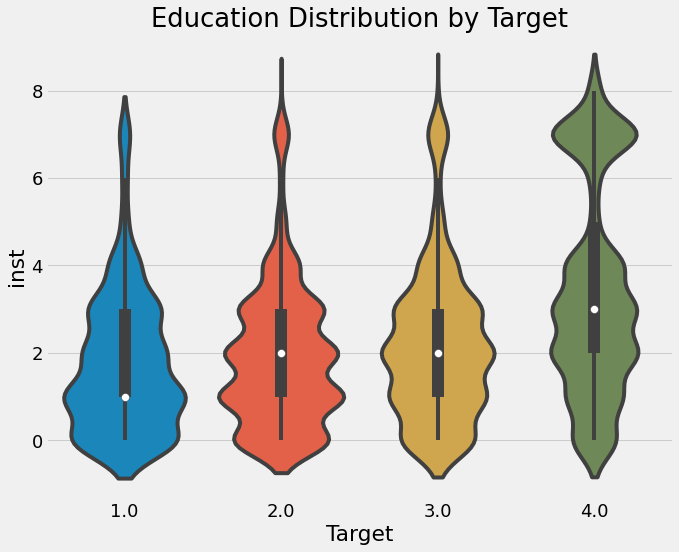

In [277]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

In [278]:
# Drop the education columns
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 40)

### Feature Construction
우리는 기존 데이터를 사용하여 몇 가지 특징을 만들 수 있다. 예를 들어, 우리는 학교 다니는 해를 나이로 나눌 수 있습니다.

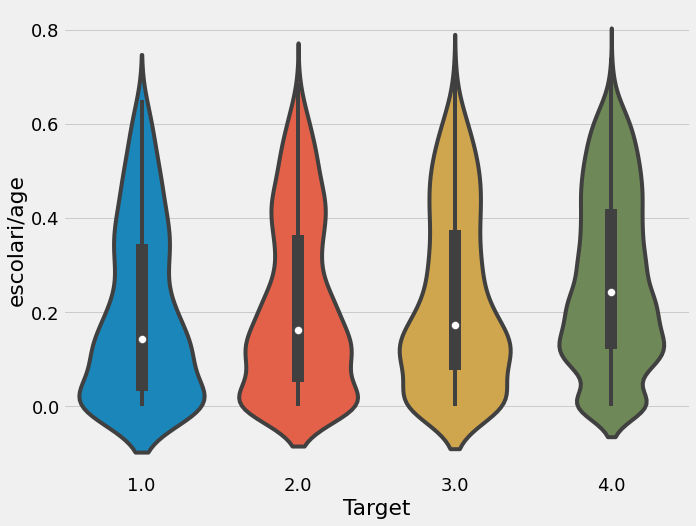

In [279]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

우리는 또한 우리의 새로운 변수를 가져와서, `inst`을 age별로 나눌 수 있다. 우리가 기술이라고 이름 붙일 마지막 변수`tech`: 이것은 태블릿과 휴대폰의 결합을 나타냅니다.

In [280]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Engineering through Aggregations
개별 데이터를 가구 데이터에 통합하기 위해서는 가구별로 집계해야 한다. 이를 위한 가장 간단한 방법은 패밀리 `Idhogar`로 `groupby`한 다음 데이터를 `agg`하는 것입니다. 순서 변수 또는 연속 변수에 대한 집계를 위해 6개를 사용할 수 있으며, 그 중 5개는 팬더에 내장되어 있으며, 그 중 1개는 우리 스스로 `range_`를 정의한다. 부울 agg은 같을 수 있지만, 이렇게 하면 중복 열이 많이 생성되어 삭제해야 합니다. 이 경우 동일한 집계를 사용한 다음 다시 돌아가서 중복 열을 삭제합니다.

In [286]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = ['Target','Id']).groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

그 한 줄만으로도 우리는 30가지 특징에서 180가지 특징을 가지고 있습니다. 그런 다음 열을 추적하기 쉽도록 이름을 바꿀 수 있습니다.

In [290]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel5-count,instlevel5-std,instlevel5-range_,instlevel6-min,instlevel6-max,instlevel6-sum,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.5,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,NaN,NaN,0.0,0,NaN,NaN,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00

In [291]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selcetion
feature selection의 첫번째 라운드로, 우리는 95보다 큰 상관 관계를 가진 모든 변수 쌍 중 하나를 제거할 수 있다.

In [296]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 109 correlated columns to remove.


열을 삭제한 다음 `heads` 데이터와 병합하여 최종 데이터 프레임을 만듭니다.

In [297]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 230)


In [298]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,...,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-count,rez_esc-std,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,NaN,NaN,0,NaN,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,NaN,NaN,0,NaN,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,NaN,NaN,0,NaN,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,2,0.707107,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,2,0.707107,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142

### Final Data Exploration
우리는 약간의 탐험을 할 것이다.

In [299]:
corrs = final.corr()['Target']

In [300]:
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [301]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

우리가 만든 변수 중 일부는 목표값과 높은 상관관계가 있음을 알 수 있습니다. 이 변수들이 실제로 유용한지 여부는 모델링 단계에서 결정될 것입니다.

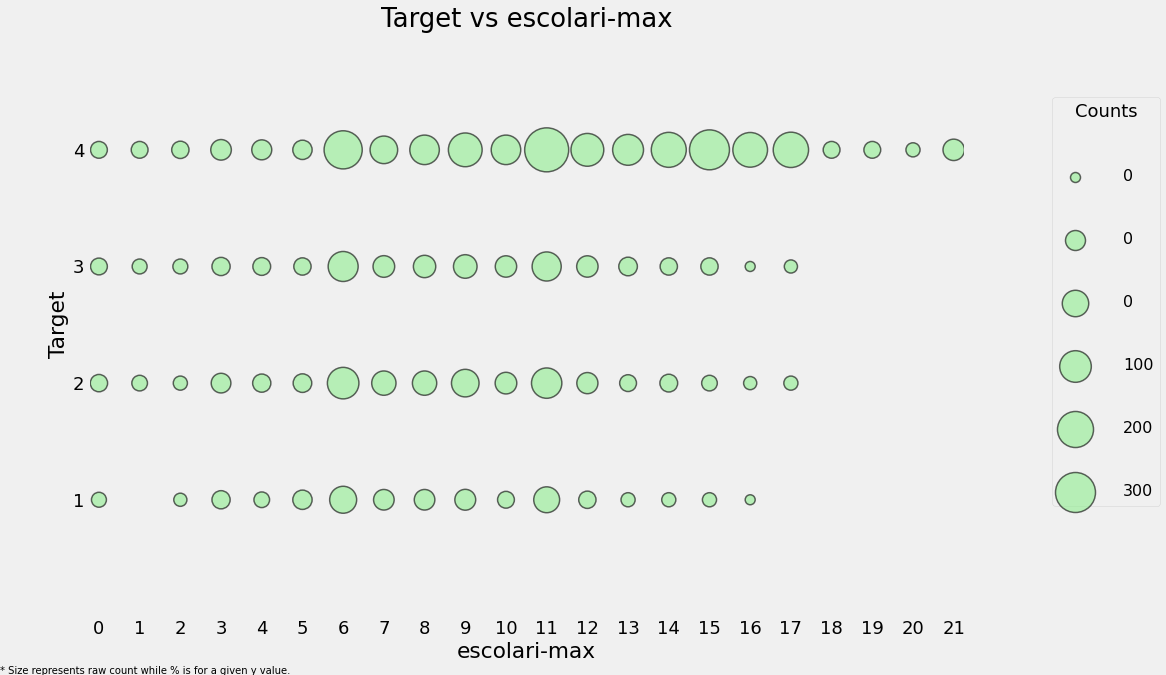

In [302]:
plot_categoricals('escolari-max', 'Target', final, annotate=False);

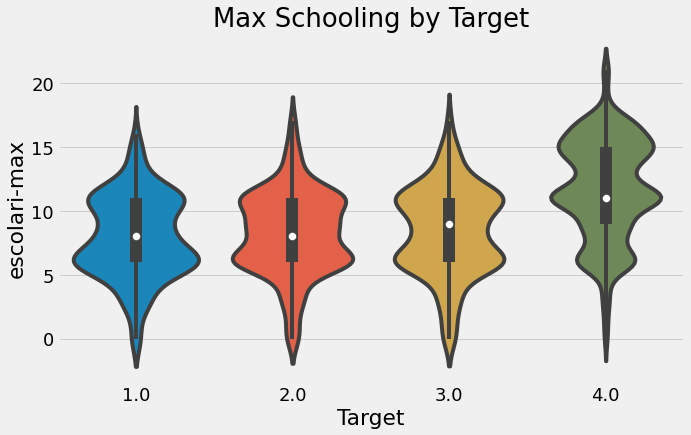

In [303]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

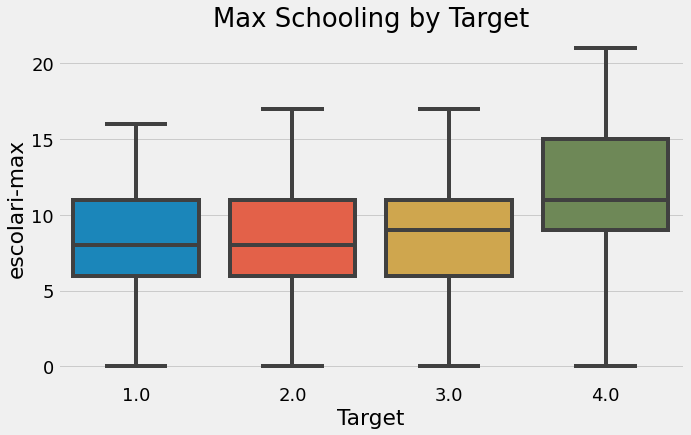

In [304]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

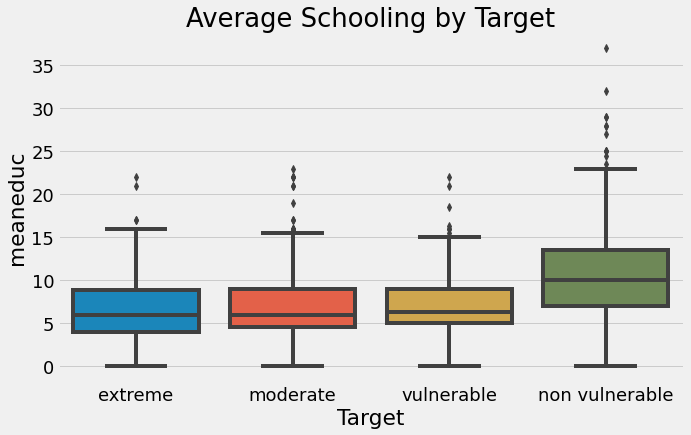

In [305]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

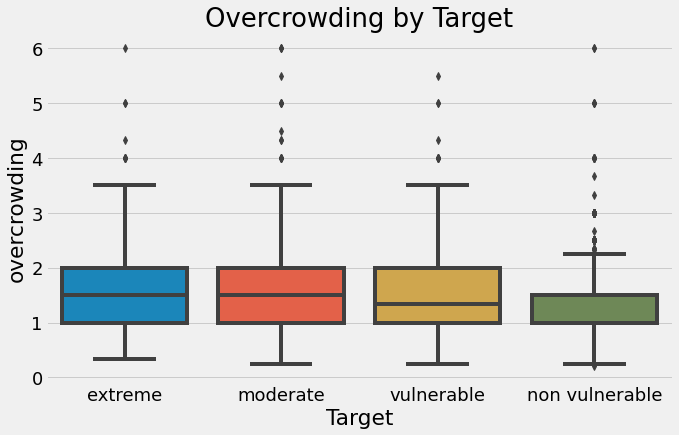

In [306]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

유용한 또 다른 특징은 가장의 성별이다. 자료를 종합했으니까 개인 수준 자료로 돌아가서 가장의 성별을 찾아야 할 것 같습니다.

In [308]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [311]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

가장이 여성인 가구는 빈곤 수준이 약간 더 높은 것으로 보인다.

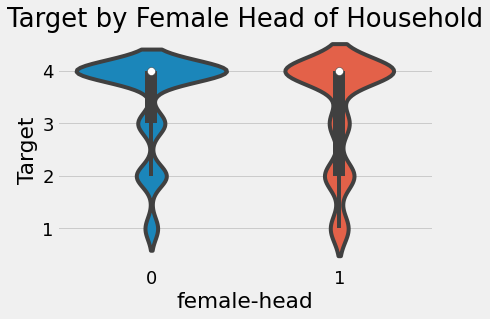

In [312]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target by Female Head of Household');

또한 가정 내 여성 가장의 유무에 의한 평균 교육의 차이도 살펴볼 수 있다.

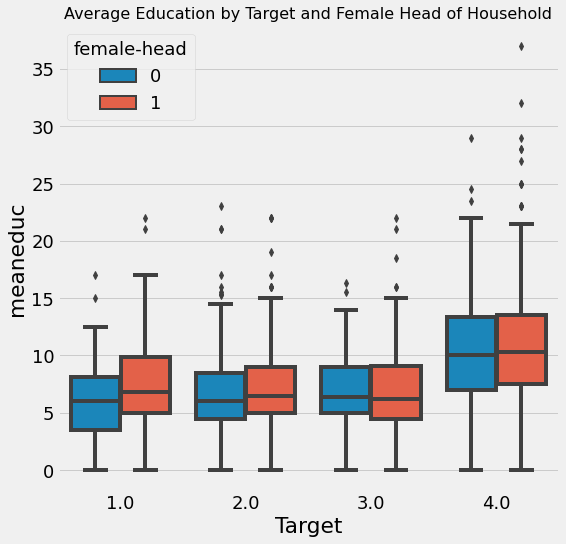

In [313]:
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'female-head', data = final);
plt.title('Average Education by Target and Female Head of Household', size = 16);

`Target`의 모든 값에서 여성 가장이 있는 가구는 더 높은 수준의 교육을 받는 것으로 보입니다. 그러나, 우리는 전반적으로, 여성 가장이 있는 가정은 심각한 빈곤을 겪을 가능성이 더 높다는 것을 보았다.

In [314]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


전반적으로 여성 가장이 있는 가구의 평균 교육이 남성 가장이 있는 가구보다 약간 높다. 나는 이것을 어떻게 해야 할지 잘 모르겠지만, 나에게는 옳은 것 같다.

# Machine Learning Modeling
feature engineering/construction이 완료되면 기계 학습을 시작할 수 있습니다. 모든 데이터(교육 및 테스트 모두)는 각 가정에 대해 집계되므로 모델에서 직접 사용할 수 있습니다. 먼저 모델링 프로세스를 보여주기 위해 Scikit-Learn에서 사용할 수 있는 랜덤 포레스트 분류기를 사용합니다. 이렇게 하면 리더 보드의 맨 위에 오르지 못할 수도 있지만 기준선을 설정할 수 있습니다. 나중에 우리는 강력한 그라데이션 부스팅 머신을 포함한 몇 가지 다른 모델들을 시도해 볼 것이다.

모델을 평가하기 위해 교육 데이터에 10-fold cross validation을 사용합니다. 이것은 본질적으로 훈련 데이터의 다른 분할을 사용하여 모델을 10번 훈련하고 테스트한다. 10-fold cross validation은 테스트 세트에서 모델의 성능을 추정하는 효과적인 방법이다. 교차 검증의 평균 성능 및 표준 편차를 검토하여 접힘 사이의 점수가 얼마나 변하는지 확인하려고 합니다. `F1 Macro` 측정값을 사용하여 성능을 평가합니다.

In [320]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross Validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [325]:
# Label for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

서로 다른 모델을 비교하기 때문에 피쳐의 크기를 조정하려고 합니다(각 열의 범위를 0과 1 사이로 제한). 많은 앙상블 모델의 경우 이것은 필요하지 않지만, K-가장 가까운 이웃(KNN) 또는 서포트 벡터 머신(SVM)과 같은 거리 메트릭에 의존하는 모델을 사용할 때는 기능 확장이 절대적으로 필요하다. 다른 모델을 비교할 때는 항상 feature을 확장하는 것이 가장 안전합니다. 또한 결측값을 형상의 중위수로 귀속시킨다.

결측값을 귀속하고 feature을 한 번에 확장하기 위해 파이프라인을 만들 수 있다. 이 값은 교육 데이터에 적합하며 교육 및 테스트 데이터를 변환하는 데 사용됩니다.

In [326]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                     ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

데이터에 결측값이 없으며 0과 1 사이에서 축척됩니다. 즉, Scikit-Learn 모델에서 직접 사용할 수 있습니다.

In [351]:
model = RandomForestClassifier(n_estimators = 100, random_state = 10, n_jobs = -1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3379 with std = 0.0443


그 점수는 좋지 않지만, 기준점이 될 것이고 우리가 개선할 수 있는 많은 여지를 남길 것이다!

## Feature Importances
tree-based model을 사용하면 모델에서 feature의 유용성에 대한 상대적 순위를 보여주는 feature importances를 살펴볼 수 있다. 이것들은 분할을 위해 변수를 사용한 노드에서의 불순물 감소의 합을 나타내지만, 우리는 절대값에 크게 신경 쓸 필요가 없다. 대신에 우리는 상대적인 점수에 초점을 맞출 것이다.

만약 feature importances을 보려면, 전체 교육 세트에서 모델을 교육해야 합니다. 교차 검증은 기능의 중요도를 반환하지 않습니다.

In [365]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000857
1,hacapo,0.000367
2,v14a,0.000377
3,refrig,0.001824
4,paredblolad,0.006881


다음은 기능 중요도를 표시하는 데 사용할 간단한 기능입니다. 나는 이 기능을 많이 사용하고 종종 스크립트 사이에 복사하여 붙여넣습니다. 설명서가 말이 됐으면 좋겠어요!

In [366]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

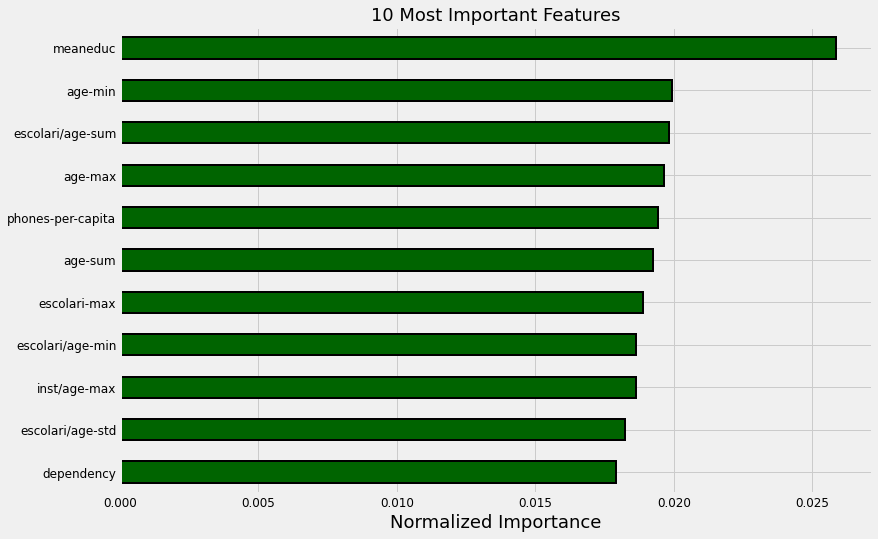

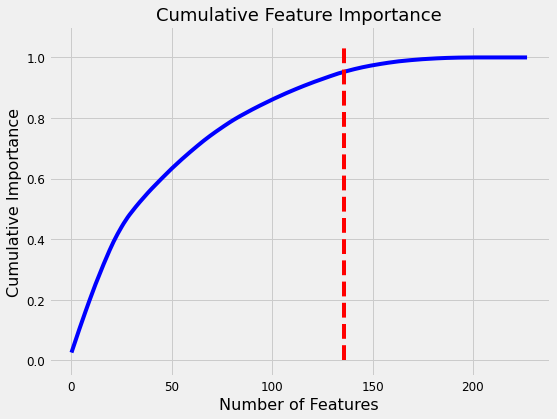

136 features required for 95% of cumulative importance.


In [367]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

**교육이 최고다!** 가장 중요한 변수는 가구당 평균 교육량이며, 가구당 모든 사람의 최대 교육량이다. 이러한 변수들이 높은 상관 관계(공선)를 가지고 있다는 것은 데이터에서 변수 중 하나를 제거하고자 할 수 있다는 것을 의미합니다. 다른 가장 중요한 특징은 우리가 만든 변수와 데이터에 이미 존재하는 변수의 조합이다.

180개 기능 중 106개만 있으면 중요도의 90%를 차지할 수 있다는 점이 흥미롭다. 이것은 우리가 일부 기능을 제거할 수 있다는 것을 말해준다. 그러나 기능 중요성은 기능의 어떤 방향이 중요한지 알려주지 않는다(예를 들어, 우리는 더 많은 또는 더 적은 교육이 더 심각한 빈곤으로 이어지는지를 구별하기 위해 이를 사용할 수 없다). 그들은 우리에게 어떤 모델이 관련이 있다고 여겨지는지 알려주기만 한다.

In [368]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

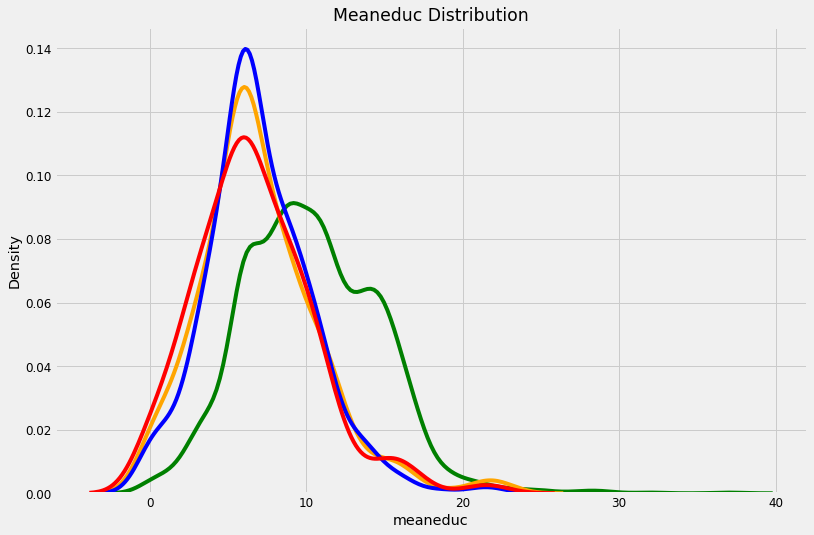

In [369]:
kde_target(final, 'meaneduc')

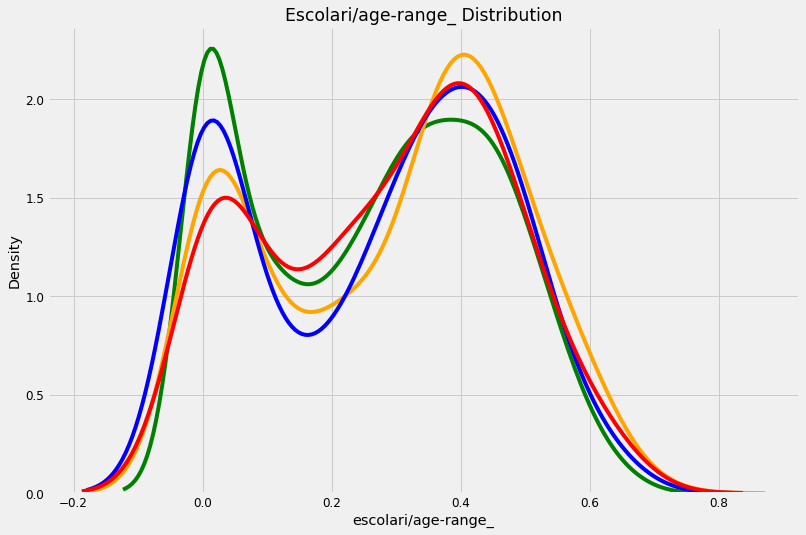

In [370]:
kde_target(final, 'escolari/age-range_')

# Model Selection
이제 여러 가지 기능이 모두 갖추어졌으므로 이제 모델링을 시작할 차례입니다. 우리는 이미 0.35의 최적의 매크로 F1을 제공하는 랜덤 포레스트 분류기라는 하나의 기본 모델을 시도했습니다. 그러나 머신 러닝에서는 주어진 데이터 세트에 어떤 모델이 가장 잘 작동하는지 미리 알 수 있는 방법이 없다. 다음 그림은 **가우스 나이브 베이즈도 그레이디언트 부스팅 기계를 능가하는 몇 가지 문제가 있음**을 보여준다. 이것은 랜달 올슨이 기계 학습의 많은 점을 논한 훌륭한 논문에서 나온 것이다.

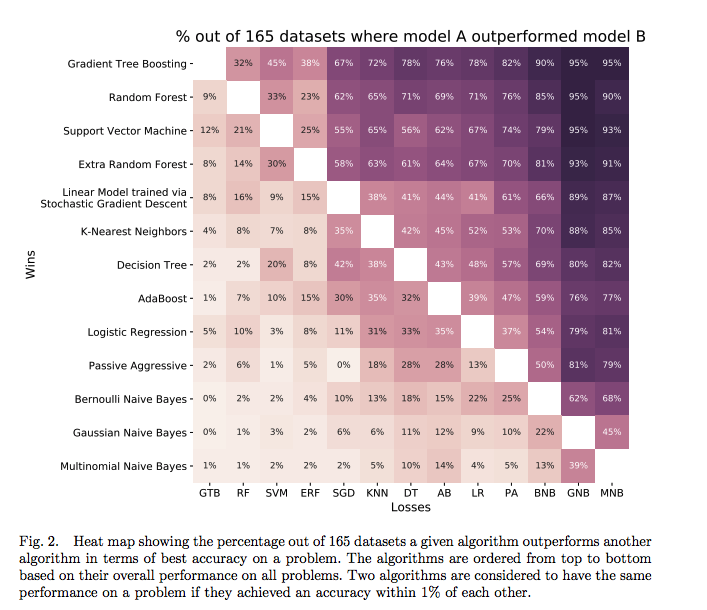

이 그림이 우리에게 말해주는 것은 어떤 것이 최적인지 보기 위해 여러 가지 다른 모델을 시도해야 한다는 것입니다. 대부분의 사람들은 결국 그레이디언트 부스팅 머신에 정착하고 우리는 그것을 시도해 볼 것이지만, 지금은 다른 몇 가지 옵션들을 살펴볼 것이다. Scikit-Learn 설명서를 보면 말 그대로 수십 개(아마도 수백 개)의 다중 클래스 기계 학습 모델이 있다. 우리는 그것들을 모두 시도해 볼 필요는 없지만, 옵션에서 샘플을 채취해야 한다.

우리가 원하는 것은 모델을 평가할 수 있는 함수를 작성하는 것입니다. 우리가 이미 대부분의 코드를 작성했기 때문에 이것은 꽤 간단할 것이다. 랜덤 포레스트 분류기 외에도 8가지 Scikit-Learn 모델을 사용해 보겠습니다. 다행히도, 이 데이터 세트는 비교적 작고 모델을 통해 빠르게 반복할 수 있다. 우리는 결과를 담을 데이터 프레임을 만들 것이고 함수는 모델별로 데이터 프레임에 행을 추가할 것이다.

In [371]:
# Model import
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [376]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring = scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name,
                                                           'cv_mean': cv_scores.mean(),
                                                           'cv_std': cv_scores.std()},
                                                          index = [0]),
                                             ignore_index = True)
    return model_results

In [377]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 'LSVC', model_results)

10 Fold CV Score: 0.28829 with std: 0.03586


이는 목록에서 지울 수 있는 모델 중 하나입니다(실제 성능을 향상시킬 수 있도록 하이퍼파라미터 조정을 수행하지는 않았지만).

In [378]:
model_results = cv_model(train_set, train_labels, GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.18515 with std: 0.03478


이 성능은 매우 형편없다. Gaussian Naive Bayes 방법을 다시 검토할 필요는 없다고 생각한다.(Gradient Boosting Machine보다 성능이 우수할 수 있는 문제가 있지만).

In [379]:
model_results = cv_model(train_set, train_labels, MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                        'MLP', model_results)

10 Fold CV Score: 0.30148 with std: 0.05914


다층 퍼셉트론(심층 신경망)은 성능이 좋다. 네트워크를 하이퍼파라미터로 조정할 수 있는 경우 이 옵션이 될 수 있습니다. 그러나 제한된 양의 데이터는 일반적으로 효과적으로 학습하기 위해 수십만 개의 예가 필요하기 때문에 신경망의 문제가 될 수 있다.

In [380]:
model_results = cv_model(train_set, train_labels, LinearDiscriminantAnalysis(),
                         'LDA', model_results)

10 Fold CV Score: 0.3158 with std: 0.05747


**`UserWarning`를 필터링하지 않고 `LinearDiscriminantAnalysis`을 실행하면 "변수가 공선입니다"라는 메시지가 많이 표시됩니다.** 그러면 일부 공선 피쳐를 제거하려는 힌트를 얻을 수 있습니다! 점수는 랜덤 포리스트와 유사하므로 공선 변수를 제거한 후 이 모형을 다시 시도해 볼 수 있습니다.

In [381]:
model_results = cv_model(train_set, train_labels, RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27938 with std: 0.03256


선형 모델(능선 정규화 포함)은 놀라울 정도로 잘 작동합니다. 이는 단순한 모델이 이 문제에 큰 도움이 될 수 있음을 나타낼 수 있습니다(하지만, 아마도 우리는 더 강력한 방법을 사용하게 될 것입니다).

In [382]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels,
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.35058 with std: 0.03484

KNN with 10 neighbors

10 Fold CV Score: 0.31945 with std: 0.02967

KNN with 20 neighbors

10 Fold CV Score: 0.30506 with std: 0.04799


한 번 더 시도하면 의사 결정 트리의 앙상블을 사용하는 랜덤 포레스트의 변형인 ExtraTreeClassifier를 고려할 것이다.

In [384]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels,
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32294 with std: 0.03725


## Comparing Model Performance
데이터 프레임의 모델링 결과를 사용하여 어떤 모델이 가장 잘하는지 확인할 수 있습니다.

In [385]:
model_results = cv_model(train_set, train_labels,
                         RandomForestClassifier(100, random_state=10),
                         'RF', model_results)

10 Fold CV Score: 0.33787 with std: 0.04434


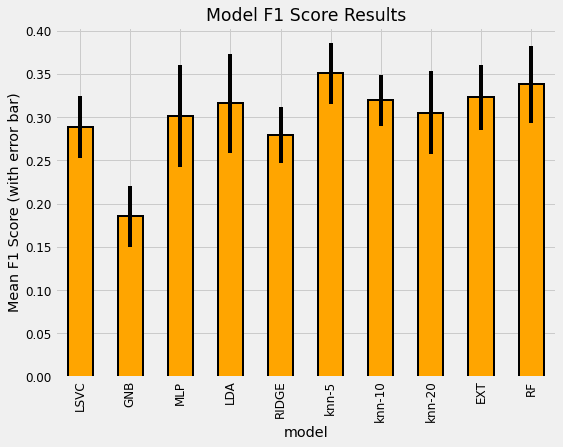

In [391]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)

plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
model_results.reset_index(inplace = True)

가장 가능성이 높은 후보는 랜덤 포레스트인 것 같습니다. 왜냐하면 랜덤 포레스트가 개봉 즉시 가장 잘 되기 때문입니다. 우리는 하이퍼 매개 변수를 조정하지 않았기 때문에 모델 간의 비교가 완벽하지 않지만, 이러한 결과는 트리 기반 앙상블 방법(그라디언트 부스팅 머신 포함)이 구조화된 데이터 세트에서 매우 잘 수행된다는 것을 발견한 다른 많은 Kaggle 경쟁자들의 결과를 반영한다. 하이퍼파라미터 성능은 기계 학습 모델의 성능을 향상시키지만, 모든 모델에 대해 가능한 모든 설정 조합을 시도할 시간이 없다. 아래 그래프(랜달 올슨의 논문)는 Scikit-Learn의 기본값 대비 하이퍼 파라미터 튜닝의 효과를 보여줍니다.

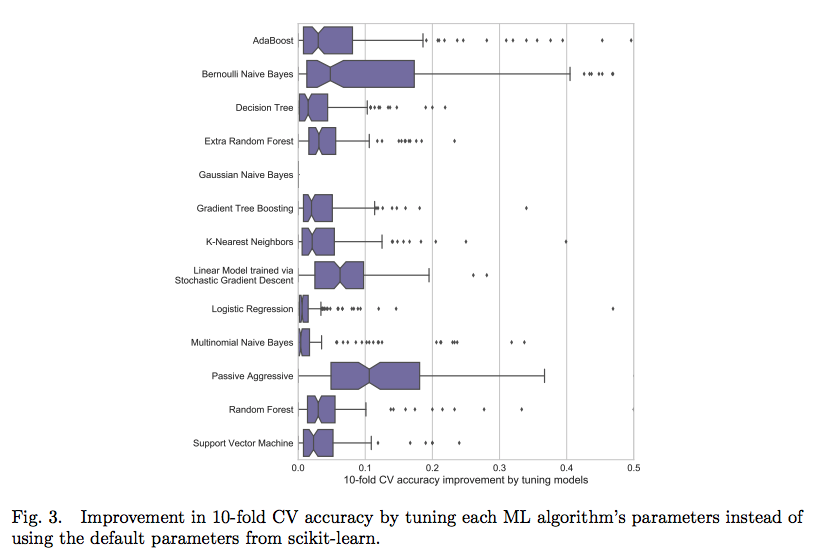

대부분의 경우 정확도가 10% 미만이기 때문에 최악의 모델이 튜닝을 통해 갑자기 최고의 모델이 되지는 않을 것입니다.

지금은 랜덤 포레스트가 제일 잘한다고 말할게요. 나중에 Scikit-Learn에서는 구현되지 않았지만 그라데이션 부스팅 머신의 사용에 대해 알아보겠습니다. 대신 보다 강력한 [LightGBM](https://lightgbm.readthedocs.io/en/latest/) 버전을 사용합니다. 이제 랜덤 포리스트를 이용한 제출로 넘어갑시다.

# Making a Submission
제출하기 위해서는 테스트 자료가 필요합니다. 다행히 열차 데이터와 정확히 동일한 방식으로 테스트 데이터가 포맷되어 있습니다.

테스트 제출의 형식은 다음과 같습니다. 가구별로 예측을 하고 있지만 실제로는 개인당 한 줄(`Id`로 식별)이 필요한데 가장에 대한 예측만 점수가 매겨진다.
```
Id,Target
ID_2f6873615,1
ID_1c78846d2,2
ID_e5442cf6a,3
ID_a8db26a79,4
ID_a62966799,4
```

`submission_base`는 각 개인에 대한 "예측"을 가져야 하기 때문에 테스트 세트에 있는 모든 개인들을 가질 것이고 `test_ids`는 가장의 `idhogar` 포함할 것이다. 예측할 때는 각 가정에 대해서만 예측한 다음 `predictions` 데이터 프레임을 가구 ID(`idhogar`)의 모든 개인과 병합한다. 이렇게 하면 한 가구의 모든 사람이 `Target`을 동일하게 설정할 수 있습니다. 가장이 없는 테스트 가구의 경우 점수가 매겨지지 않기 때문에 이러한 예측을 4로 설정할 수 있습니다.

In [394]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

아래 기능은 모델, 교육 세트, 교육 라벨 및 테스트 세트를 가져와 다음 작업을 수행합니다.
- `fit`을 사용하여 교육 데이터에 대한 모델을 학습
- `predict`를 사용하여 검정 데이터에 대한 예측
- competition에 저장 및 업로드할 수 있는 `submission` 데이터프레임 생성